# Analysis of single-plex TMT experiment: compare edgeR to t-test

## Comet/PAW pipeline


### Phil Wilmarth, OHSU PSR Core, April 2019

## Overview and objectives

Most ways that isobaric labeling data are analyzed hinder statistical testing and data visualization. This notebook will analyze data from (**Ref-1**) to demonstrate a two-condition (3 controls and 4 treatments) comparison done with 10-plex TMT reagents using the SPS MS3 method (**Ref-2**) on a Thermo Fusion instrument. The notebook will show how to:

- load in a complicated results table and extract the data
- normalize the data and check the result
- compare the two conditions using edgeR
- compare the two conditions using t-test
- compare edgeR results to t-test results

## Experiment background and PAW data processing

The KUR1502 data were mouse bone marrow cell cultures where the "media" samples are controls (one of the 4 did not label) and there are leukemia exosome-dosed cells (4 "exosome" samples). 10-plex TMT was used on a Thermo Fusion using the SPS MS3 method. The [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) (**Ref-3**) is our in-house processing using the Comet search engine (**Ref-4**). The pipeline converts the RAW files into text files using MSConvert from the Proteowizard toolkit (**Ref-5**).

Data from the MS2 scans are extracted for the Comet searches and the reporter peak heights are extracted from the MS3 scans. The pipeline uses the target/decoy method to make score histograms and determine score filtering thresholds. Accurate mass is used to create conditional score histograms where target/decoy delta mass histograms are used to set the accurate mass windows. Basic parsimony principles are used for protein inference and 2 peptides per protein were required. An additional protein grouping step was used to combine nearly identical peptide sets (often these are housekeeping genes).

> **1.** Huan, J., Hornick, N.I., Goloviznina, N.A., Kamimae-Lanning, A.N., David, L.L., Wilmarth, P.A., Mori, T., Chevillet, J.R., Narla, A., Roberts Jr, C.T. and Loriaux, M.M., 2015. Coordinate regulation of residual bone marrow function by paracrine trafficking of AML exosomes. Leukemia, 29(12), p.2285.

> **2.** McAlister, G.C., Nusinow, D.P., Jedrychowski, M.P., Wühr, M., Huttlin, E.L., Erickson, B.K., Rad, R., Haas, W. and Gygi, S.P., 2014. MultiNotch MS3 enables accurate, sensitive, and multiplexed detection of differential expression across cancer cell line proteomes. Analytical chemistry, 86(14), pp.7150-7158.

> **3.** Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> **4.** Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24.

> **5.** Chambers, M.C., Maclean, B., Burke, R., Amodei, D., Ruderman, D.L., Neumann, S., Gatto, L., Fischer, B., Pratt, B., Egertson, J. and Hoff, K., 2012. A cross-platform toolkit for mass spectrometry and proteomics. Nature biotechnology, 30(10), p.918

## Differential expression (DE) testing

There are some hidden constraints in these experimental designs. The total amount of protein is usually fixed at the same value across all samples (an individual biological replicate). High abundance proteins are constrained by the total protein amount and do not have the same freedom for abundance differences that proteins that are smaller fractions of the total have. Higher abundance proteins must, by experimental design, have moderated differences in means and reduced variances. Lower abundance proteins have more freedom and will not be as constrained.

The constrained nature of these experimental designs (both genomics and proteomics) has implications in normalization algorithms. An increased expression in abundant proteins will "push" all other proteins down (their abundance total has to remain the same). Grand total normalization like we use above can be too simplistic. The differential expression testing package edgeR (**Ref-6**) includes a trimmed mean of M values (TMM) normalization step (**Ref-7**) designed for these types of samples.

> **6.** Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> **7.** Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

---

### Load libraries, data file, and edgeR data objects

In [1]:
# load libraries
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 

# read the grouped protein summary file
paw_raw <- read_tsv("grouped_protein_summary_TMT_8_sorted.txt", skip = 4,
                    n_max = 5427, guess_max = 5427)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following objects are masked from ‘package:psych’:

    alpha, rescale

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Parsed with column specification:
cols(
  .default = col_number(),
  ProtGroup = col_double(),
  Counter = col_double(),
  Accession = col_character(),
  I

In [2]:
# extract protein accession column and TMT data
# need to exclude any rows with an entry in "Filter" column
# there are also 4 unused channels (of the 11-plex slots)
paw_tmt <- paw_raw %>% 
  filter(., is.na(Filter)) %>%
  select(Accession, starts_with("TotInt_")) %>%
  select(-contains("127N"), -contains("128N"), -contains("130N"), -contains("131C"))

# separate accessions from the data
accession <- paw_tmt$Accession
paw_tmt <- paw_tmt %>% select(-Accession)

# rename the columns and gather the conditions
colnames(paw_tmt) <- c("Media_2.1", "Exo_2.1", "Exo_2.2", "Media_2.2",
                      "Exo_3.1", "Exo_3.2", "Media_3.2")
paw_tmt <- paw_tmt %>% select(contains("Media"), contains("Exo"))

head(paw_tmt)
nrow(paw_tmt)

Media_2.1 Media_2.2 Media_3.2 Exo_2.1 Exo_2.2 Exo_3.1 Exo_3.2
1 3933357   4407161   3673067   3365868 2877318 4087298 4900769
2 5776706   7291692   5960994   6059613 4975721 7275906 8452274
3 1014940   1257965   1085345    960414  817656 1651860 1998265
4 6870884   8431112   6883385   5565945 4276295 7595261 8567091
5 5581931   7025343   6028481   5919861 4716778 7657665 8385431
6 5784291   7072911   5227963   5569973 4762455 6382760 6863332

[1] 4976

In [3]:
# load data into DGEList object
group <- c(rep("media", 3), rep("exosome", 4))
y <- DGEList(counts = paw_tmt, group = group, genes = accession)
y$samples

group   lib.size   norm.factors
Media_2.1 media   1027236544 1           
Media_2.2 media   1269260855 1           
Media_3.2 media    916023072 1           
Exo_2.1   exosome  751966489 1           
Exo_2.2   exosome  615347770 1           
Exo_3.1   exosome  829342908 1           
Exo_3.2   exosome  943200022 1

### Normalize the TMT data

EdgeR normalization is actually done in two steps. The first, called a library size adjustment, is like the SL normalization we did above. This gets the rid of the big differences between samples so that the TMM algorithm has better starting data. We need to compute the normalized intensities from the TMM factors.

Overall Factors (lib.size+TMM):
 Media_2.1 -> 0.856378
 Media_2.2 -> 0.686205
 Media_3.2 -> 0.966401
 Exo_2.1 -> 1.217162
 Exo_2.2 -> 1.475263
 Exo_3.1 -> 1.143810
 Exo_3.2 -> 1.005158


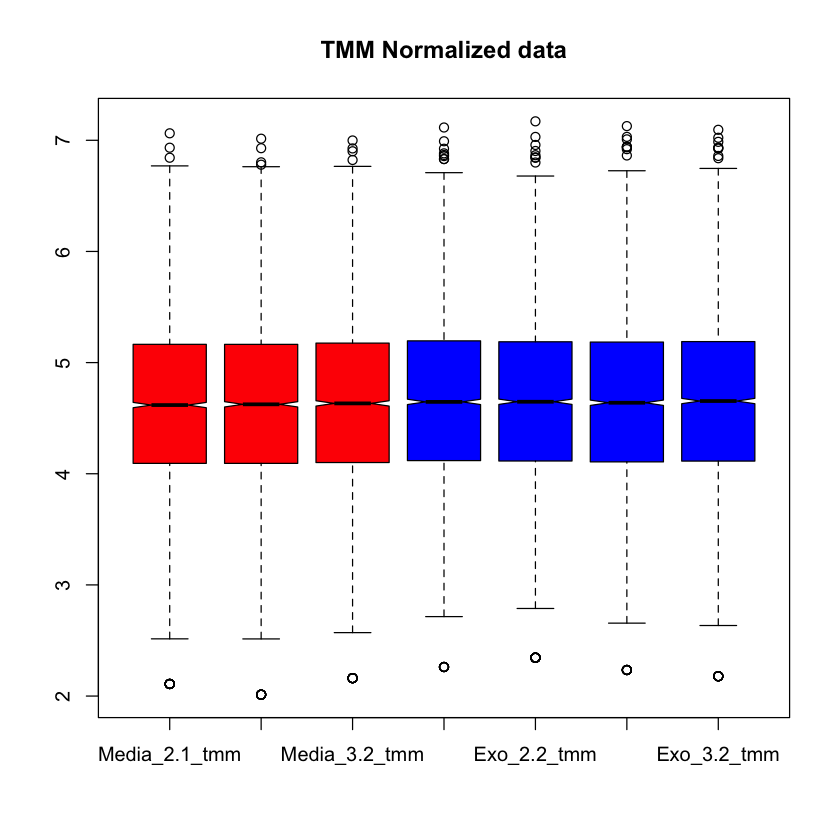

In [4]:
# run the TMM normalization
y <- calcNormFactors(y)

# set colors for plotting
color <- c(rep("red", 3), rep("blue", 4))

# function to compute the normalized intensities
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# get the normalized data values
paw_tmt_tmm <- apply_tmm_factors(y, color)

### Compute dispersion for modeling

Design matrix not provided. Switch to the classic mode.


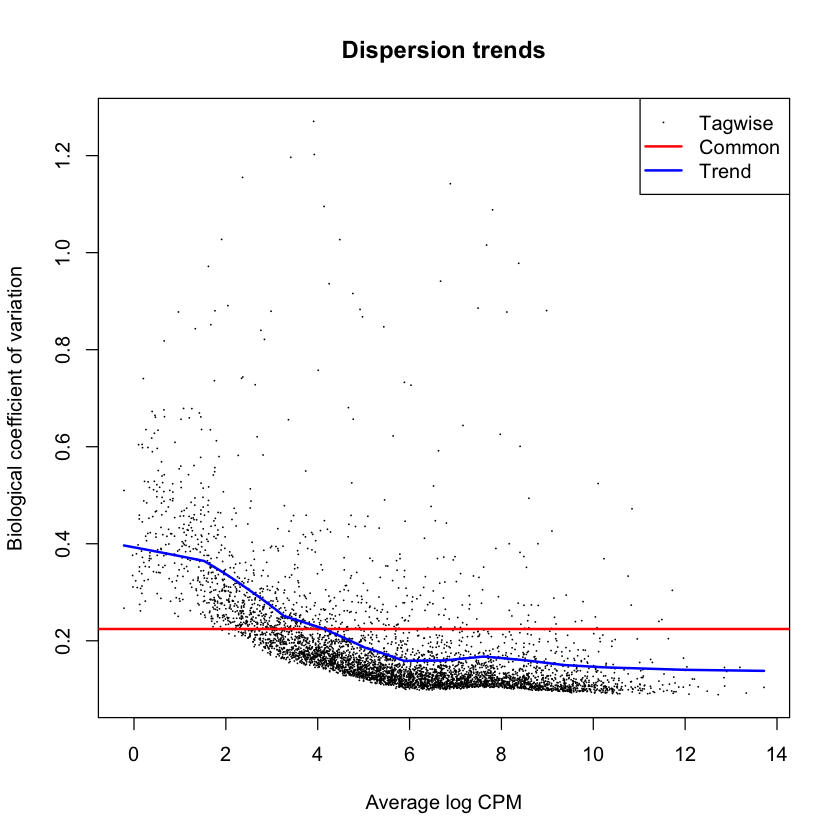

In [5]:
# we need to get dispersion estimates
y <- estimateDisp(y)
plotBCV(y, main = "Dispersion trends")

## Dispersion depends on the protein intensity

There are abundance-dependent dispersion effects in many measurement methods. Higher abundance signals have better signal-to-noise (or are the result of more averaging), so they can appear more precise than lower abundance signals. We see that the trended variance blue line increases as the protein intensity decreases. The statistical testing will use trended variances (estimated from multiple proteins) **as a function of** protein intensity, which spans several orders of magnitude. EdgeR puts the data on a common "counts per million" scale. The library size and TMM scaling factors essential normalize the total signal per channel to 1.0. Multiplying by one million is done to convert to the CPM scale.

There are two important observations about the data and the blue line. The blue line is greater than the per protein variances for most proteins (the region with log CPM between 4 and 8 is a good example). This prevents proteins with small mean difference that might also have atypically low variance from throwing really small p-values. This is a nice consequence. 

There is also a flip side. Some of the proteins have variances that are greater than the blue line. If they have larger differences in means, the lower trended variance rather than their higher direct variances will result in small p-values. Real sample contaminant proteins (such as from surrounding tissue in dissections) can vary sample-to-sample, have high variance, and potentially be biased among conditions. These proteins might not have small p-values in traditional tests despite large differences in means if the variance is also large.

### edgeR exact test

We will use the exact test in edgeR for this simple two-state comparison. You may wonder why we are using statistical testing built on a negative binomial distribution for counting experiments. The shortest answer is because it seems to work okay. The variance is modeled by two terms: one for Poisson numbers and an over-dispersion term. As counts get larger (several hundred or so), the Poisson term becomes small and the variance is handled by the over-dispersion term. The values of reporter ion peak heights, particularly when summed into protein totals, are large numbers. After we get the results from edgeR, we will compare them to a two-sample t-test, which uses a normal data distribution.  

In [6]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))

    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("media", "exosome"))

# define variables for the columns in each condition
M <- 1:3
E <- 4:7

# make the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
med_exo <- collect_results(paw_tmt_tmm, tt, M, "med", E, "exo")

### Run test and reformat results

The `exactTest` function does the modeling for the specified pair. More than one pair can be present in DGEList objects to improve the dispersion estimates. The `topTags` function does the multiple testing corrections and returns more concise summaries of the testing results. The `collect_results` function combines some of the normalized data and test results into a sufficient results data frame.

### Check if testing looks okay

It is important to see if the modeling looks reasonable. Our general assumptions are that we have a large fraction of the proteins that are not differentially expressed. Those will have a uniform (flat) p-value distribution from 0.0 to 1.0. We also expect (hopefully) some true differential expression candidates. Those should have very small p-values and have a sharper distribution at low p-values. 

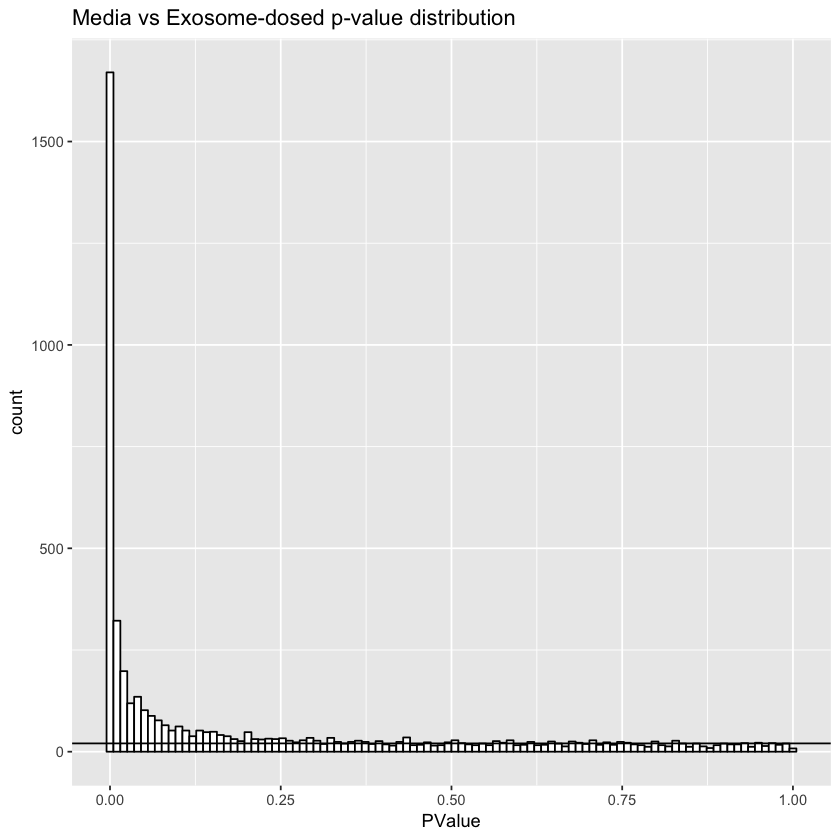

In [7]:
pvalue_plot <- function(results, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # title - plot title
    ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100])) +
        ggtitle(str_c(title, " p-value distribution"))
}

# check the p-value distrubution
pvalue_plot(med_exo, "Media vs Exosome-dosed")

### We have the expected distributions

We have the two expected distributions of p-values, so the testing seems reasonable. We can also see how the up-regulated protein number compares to the down-regulated number. We can use the `topTags` function to see which proteins have the smallest p-values.

In [8]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# see which proteins have the smallest p-values
topTags(et)$table

       exosome-media
Down            1236
NotSig          2487
Up              1253

genes                 logFC    logCPM    PValue        FDR          
4640 sp|Q3UHQ6|DOP2_MOUSE  9.500352  5.836843 1.552477e-187 7.725127e-184
3419 sp|P22777|PAI1_MOUSE  3.785082  3.953547  5.236968e-53  1.302958e-49
4939 sp|Q9QXV1|CBX8_MOUSE  7.129619  6.307572  3.877339e-51  6.060352e-48
450  sp|P54987|IRG1_MOUSE  2.509351 10.097597  4.871666e-51  6.060352e-48
4504 sp|Q9JM51|PTGES_MOUSE 2.278748  5.963784  2.837318e-48  2.823699e-45
4148 sp|P04918|SAA3_MOUSE  3.385478  3.633576  9.952807e-48  8.254195e-45
3118 sp|P33766|FPR1_MOUSE  2.829381  5.537600  1.030196e-46  7.323219e-44
530  sp|Q9R0P3|ESTD_MOUSE  1.616199 10.016199  1.798983e-44  1.118967e-41
4404 sp|Q91XA2|GOLM1_MOUSE 4.487636  5.889516  7.891854e-44  4.363319e-41
1252 sp|P35173|CYT3_MOUSE  2.705802  8.965056  1.363845e-42  6.786495e-40

### We can categorize candidates by ranges of adjusted p-values

In many discovery experiments, a Benjamini-Hochberg adjusted p-value (FDR) cutoff of 0.05 might be pretty strict. I like to use a 10% cutoff to distinguish DE from non-DE candidates. We define three cuts on the FDR: 10% to 5% are "low" significance, 5% to 1% are medium significance, and less than 1% are more "highly" significant. Cut values can be adjusted depending on the experimental situation.

We can look at expression ratio distributions as a function of candidate category. If variance is not too variable protein-to-protein, then we would expect larger mean differences to be associated with lower FDR values. Faceted plotting in ggplot2 is a nice way to show such things.

candidate n   
1 high      1580
2 med        534
3 low        375
4 no        2487

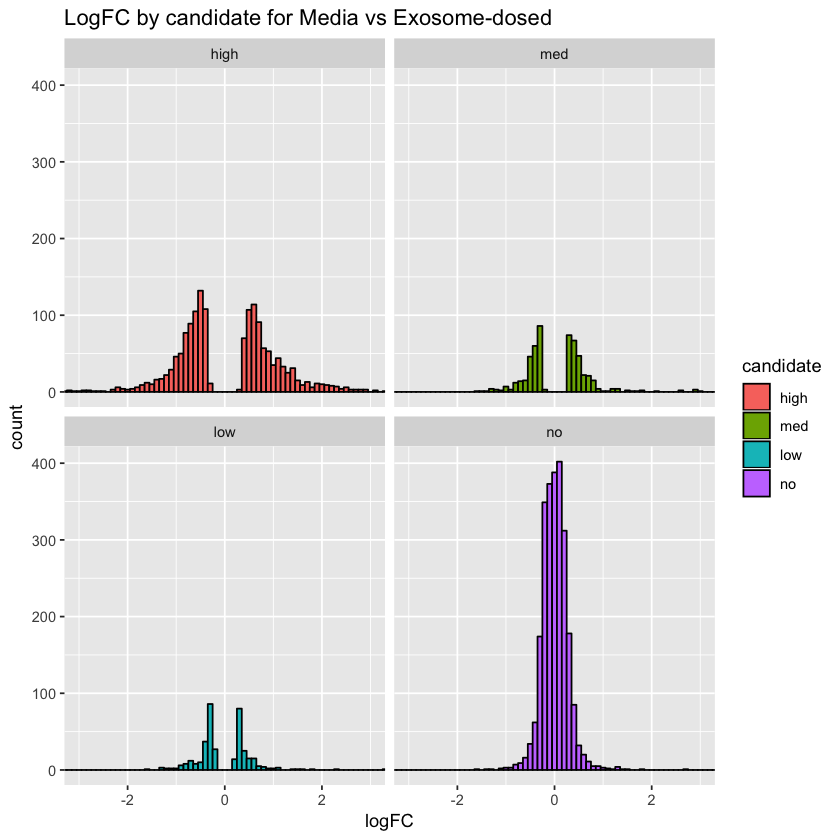

In [9]:
# see how many candidates are in each category
med_exo %>% count(candidate)

log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# can look at log2FC distributions as a check
log2FC_plots(med_exo, 3, "LogFC by candidate for Media vs Exosome-dosed")

### Visualize the edgeR DE candidates

- MA plots
- scatter plots
- volcano plot

We need some transformed axes for MA plots and for volcano plots. We will make a function for that and also some functions for the plotting. [MA plots](https://en.wikipedia.org/wiki/MA_plot) are first up. The dotted lines indicate 2-fold changes.

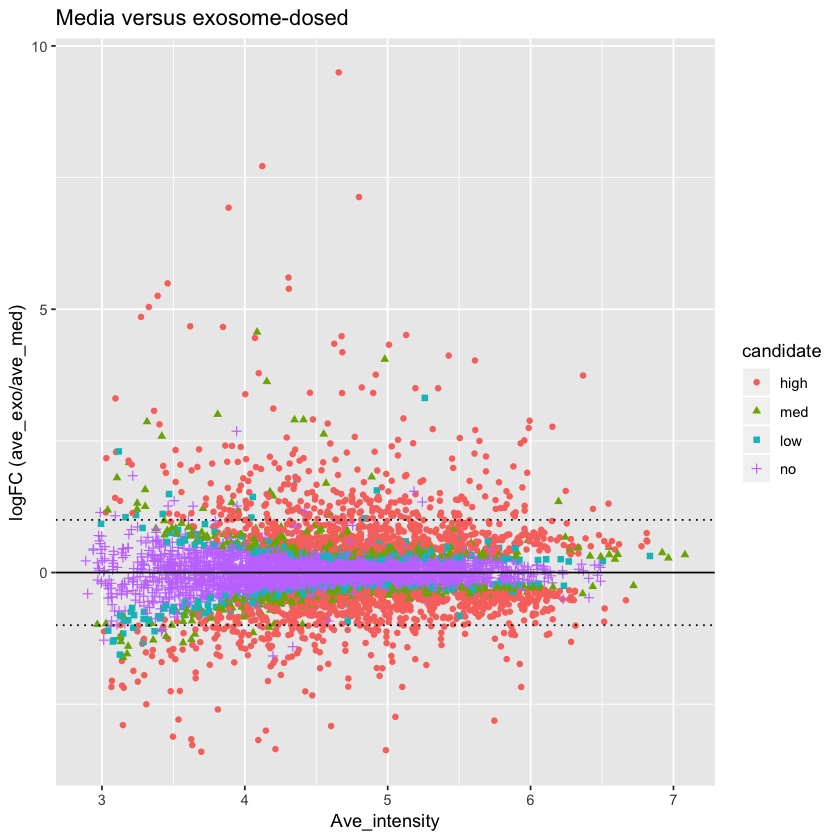

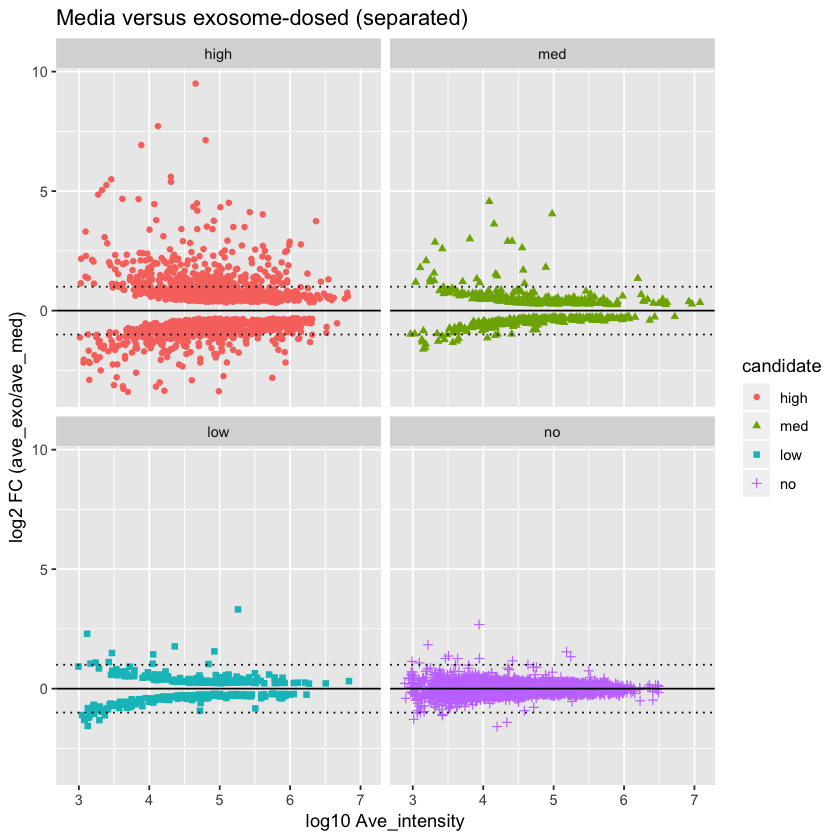

In [10]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    df # return the frame
}

MA_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    if (make_facet == TRUE) {
        ma_facet <- ggplot(temp, aes(x = A, y = M)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
            scale_x_continuous("log10 Ave_intensity") +
            ma_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)"))
    }

    # make the plots visible
    print(ma)
    if (make_facet == TRUE) {
        print(ma_facet)
    }
}    

# MA plots of DE candidates
MA_plots(med_exo, "ave_med", "ave_exo", "Media versus exosome-dosed")

### Scatter plots

The solid diagonal line is 1:1, the dotted lines are 2-fold changes. The axes are in log scale.

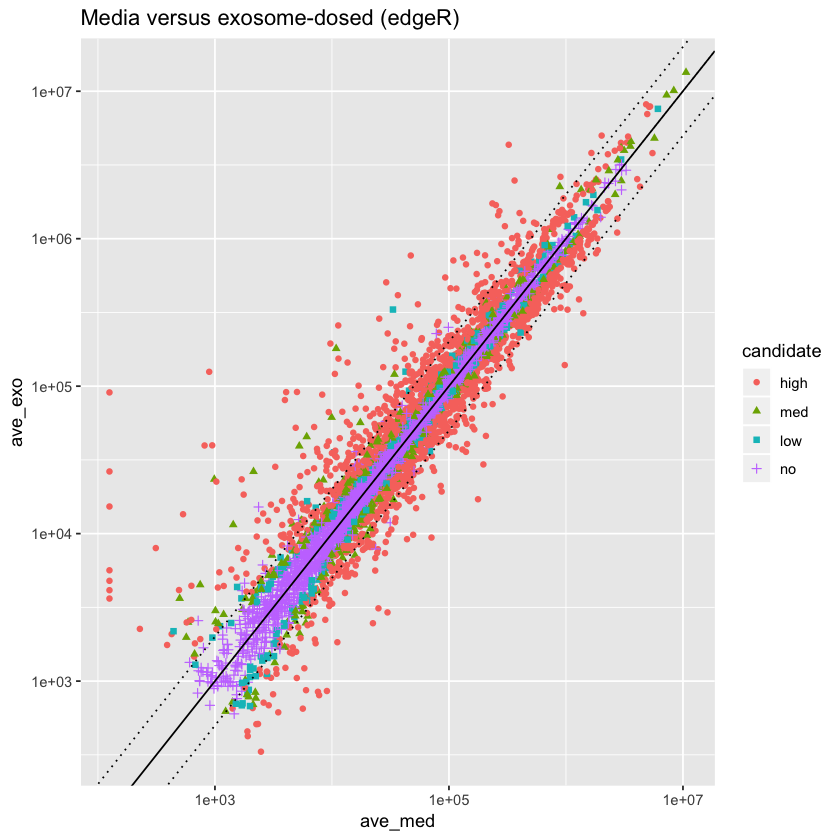

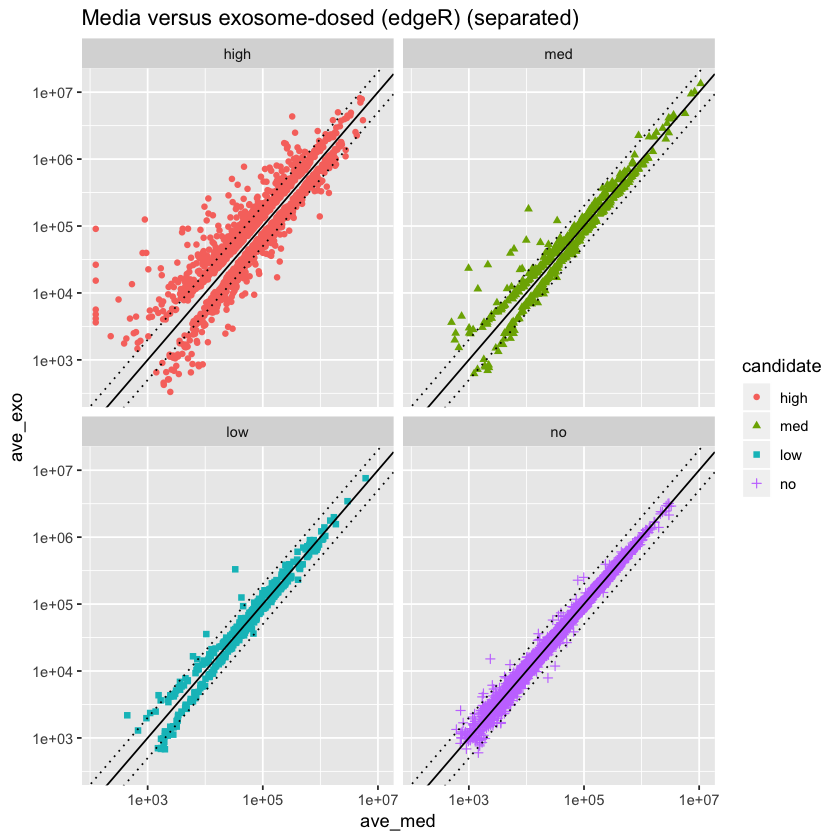

In [11]:
scatter_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    if (make_facet == TRUE) {
        scatter_facet <- ggplot(results, aes_string(x, y)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scatter_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)")) 
    }

    # make the plots visible
    print(scatter)
    if (make_facet == TRUE) {
        print(scatter_facet)
    }
}

scatter_plots(med_exo, "ave_med", "ave_exo", "Media versus exosome-dosed (edgeR)")

### Volcano plot

Volcano plots are another common way to visualize DE candidates.

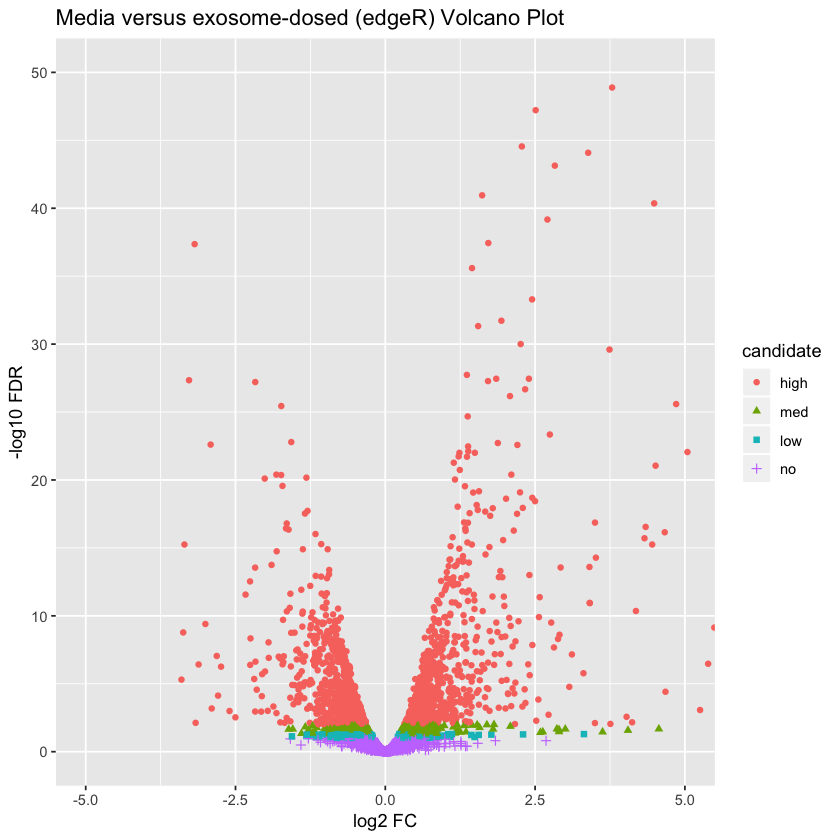

In [12]:
volcano_plot <- function(results, x, y, title, ymax) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # ymax - upper limit for y-axis
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        coord_cartesian(xlim = c(-5, 5), ylim = c(0, ymax)) + 
        ggtitle(str_c(title, " Volcano Plot"))
}

# finally, a volcano plot
volcano_plot(med_exo, "ave_med", "ave_exo", "Media versus exosome-dosed (edgeR)", 50)

### Plot the channel intensities for some of the top candidates by FDR

We can see how the intensities of the individual samples compare for the **top 10** up- and down-regulated candidate proteins.

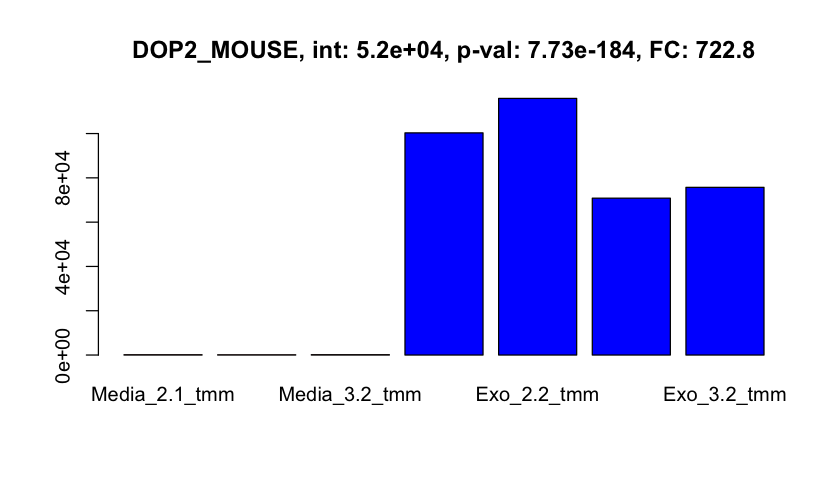

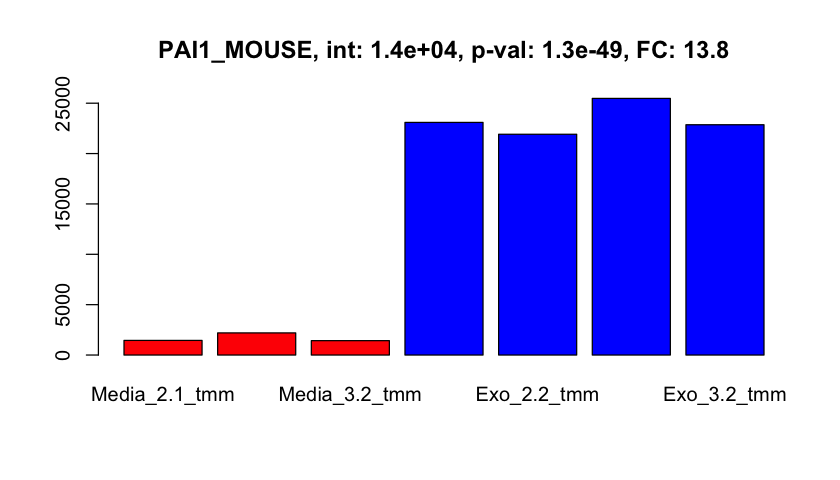

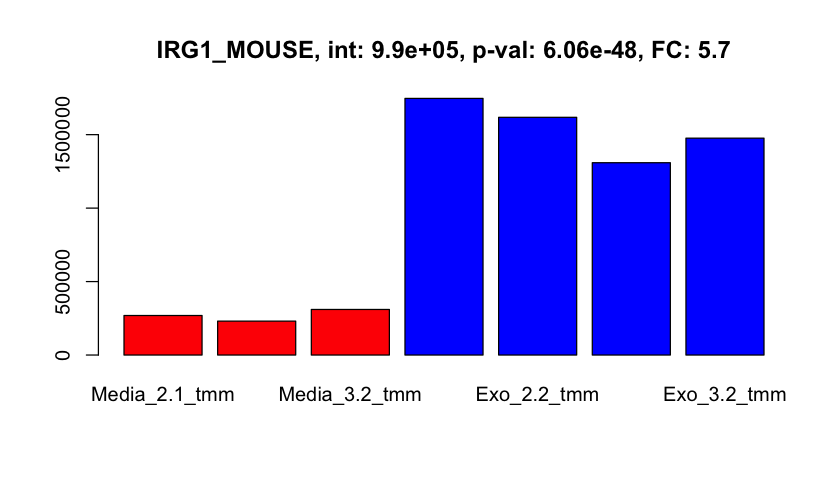

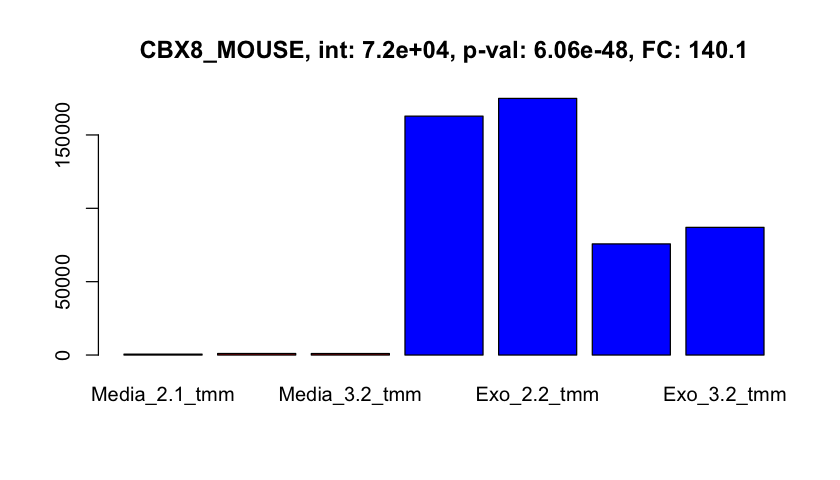

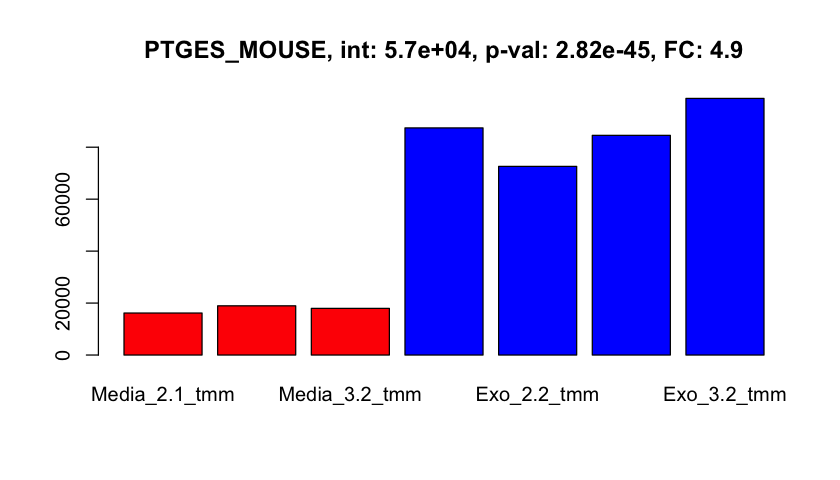

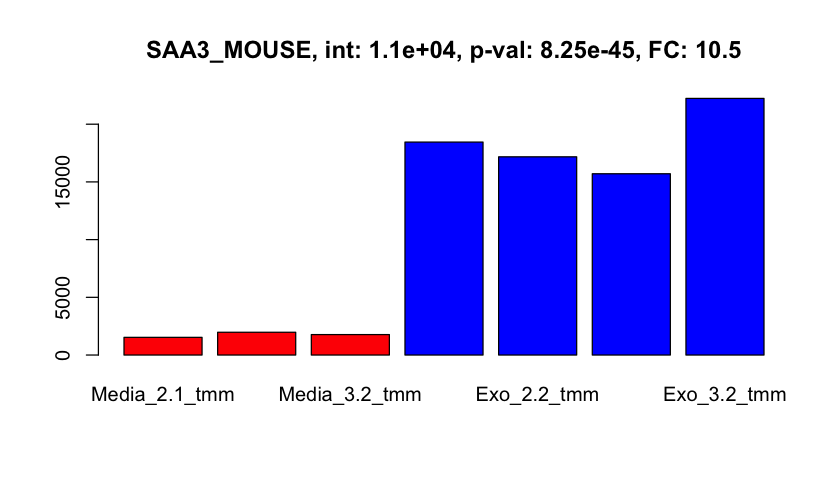

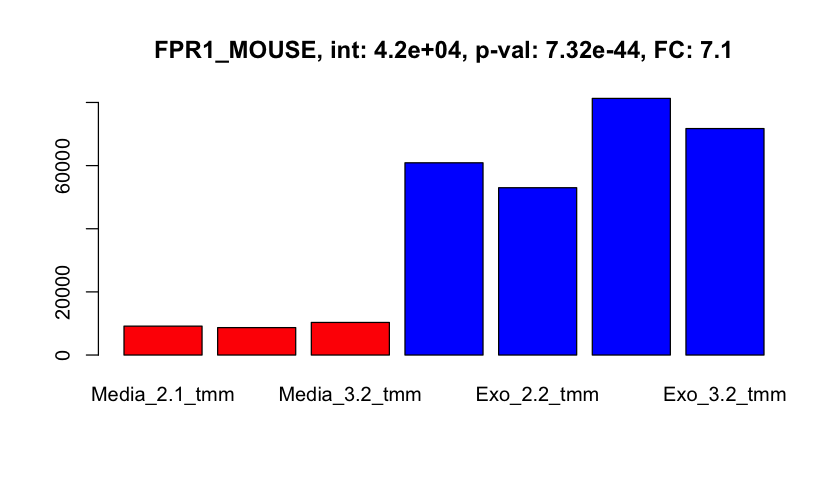

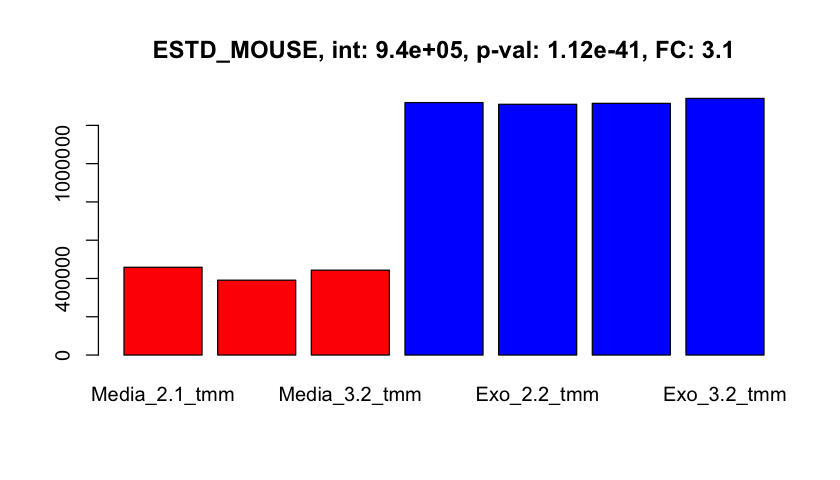

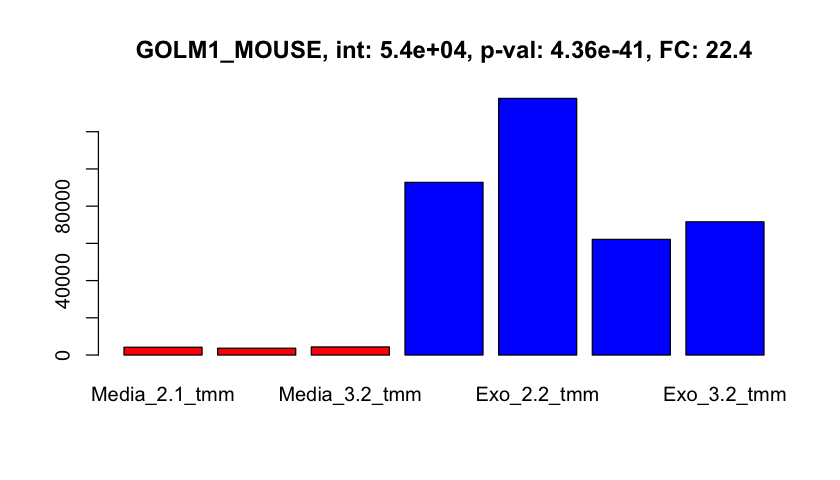

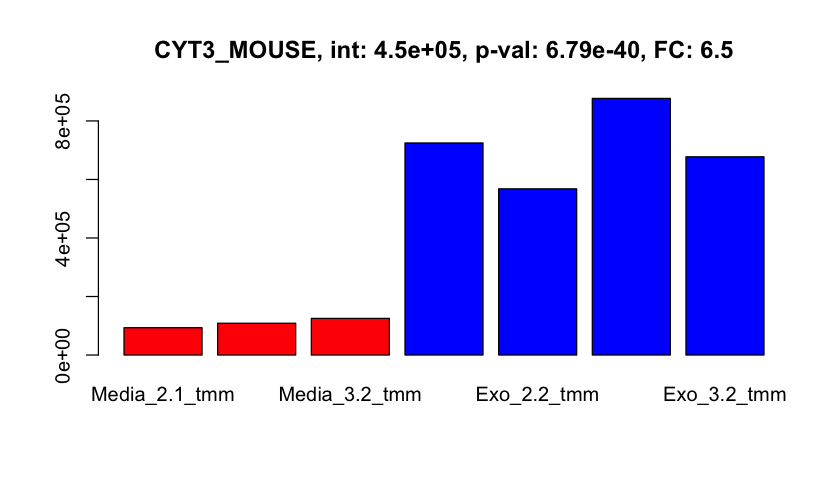

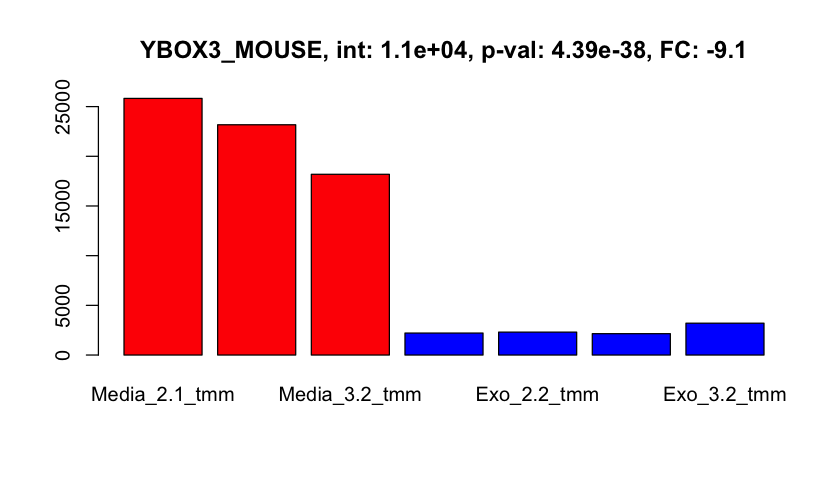

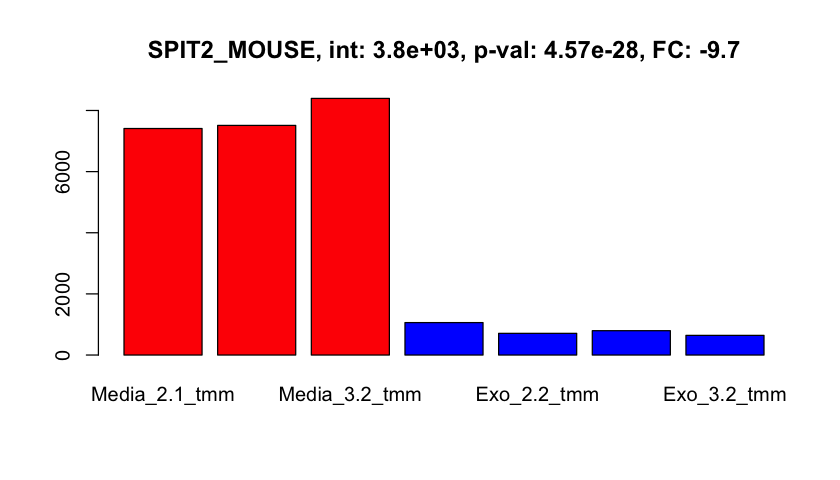

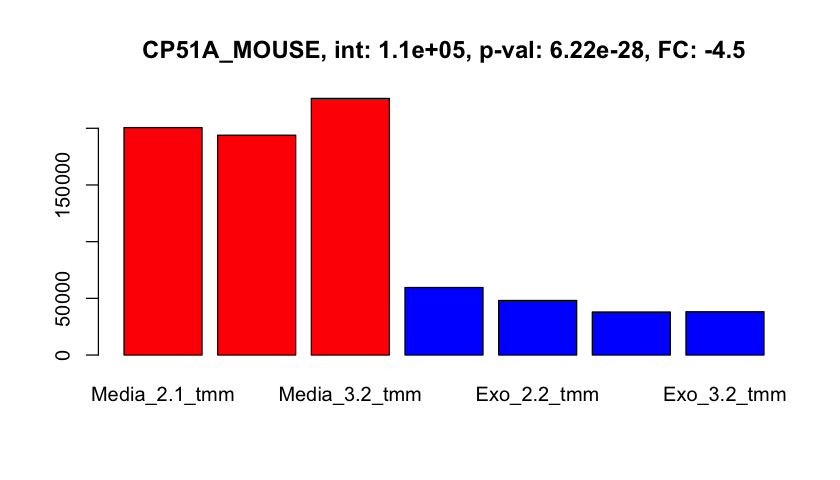

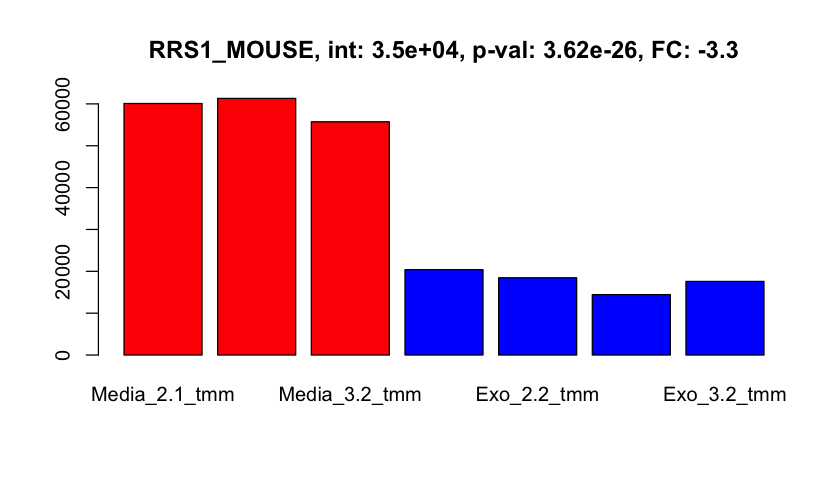

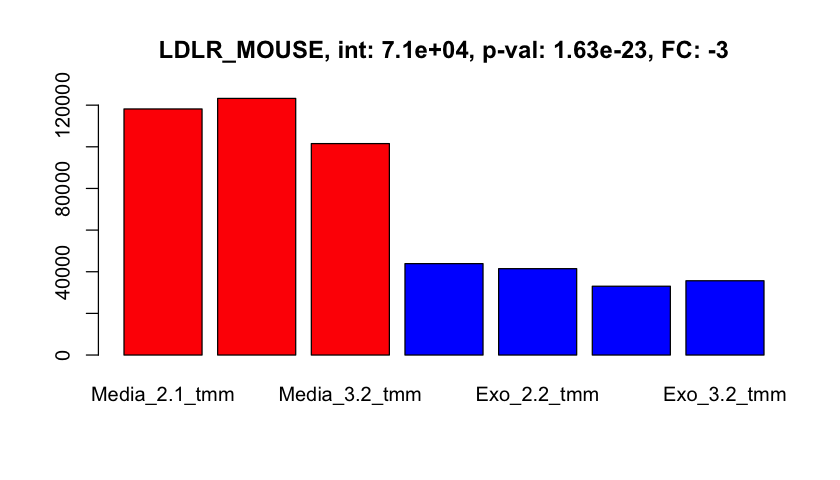

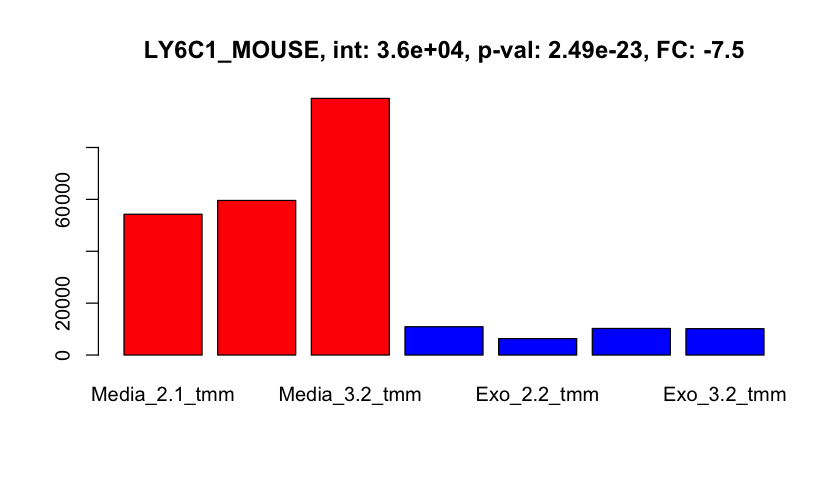

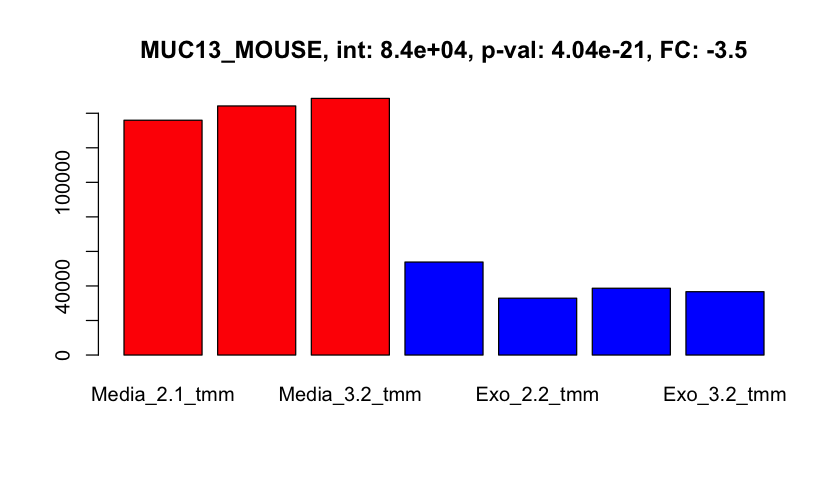

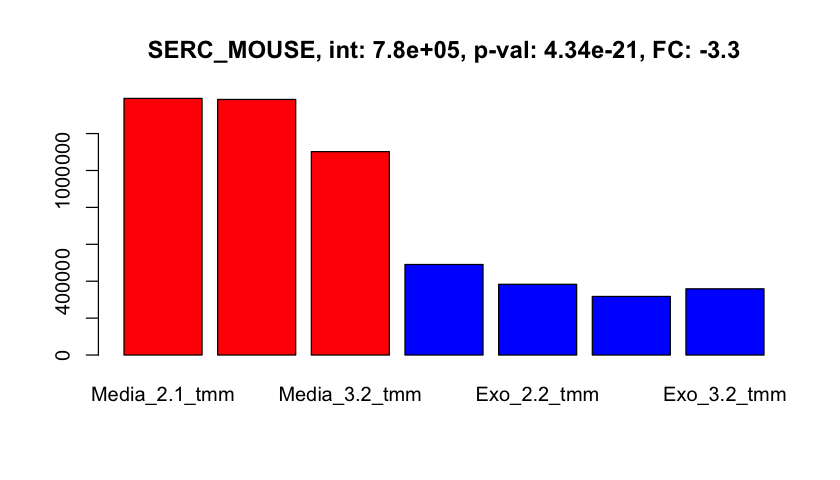

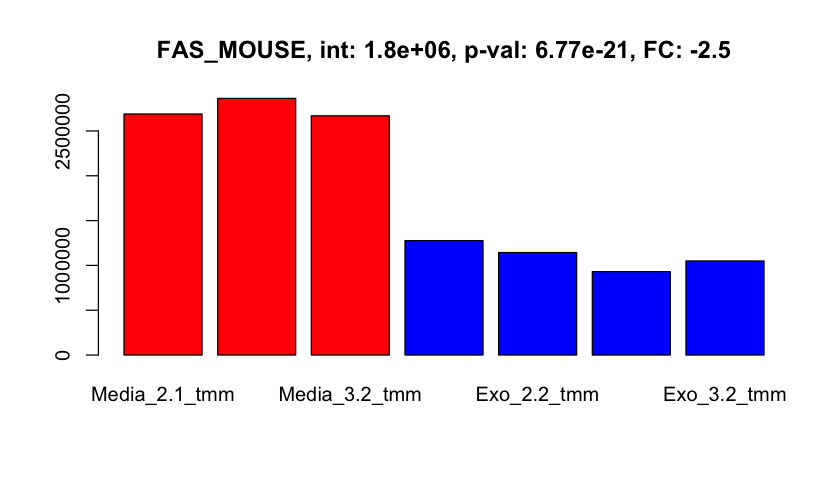

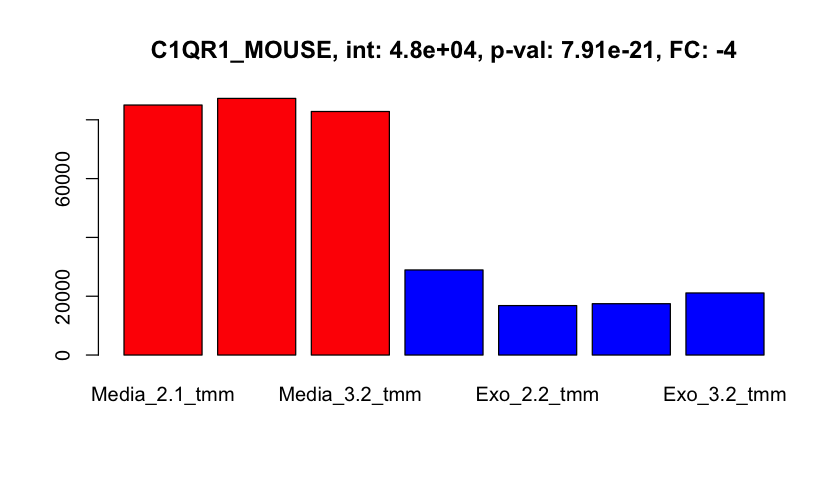

In [13]:
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top up-regulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down-regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

# plot the top 10 up and 10 down proteins
set_plot_dimensions(7, 4)
plot_top_tags(med_exo, 3, 4, 10)
set_plot_dimensions(7, 7)

### Summary of edgeR testing

EdgeR normalizations and testing seemed reasonable for this data. 

- non-DE candidate much less than 2-fold (most are closer to 1:1)
- larger fold changes associated with more significant candidates
- wider dispersion at lower intensities is incorporated into edgeR testing
  - need larger fold changes at lower intensities to get the same significance
- proteins with larger fold-changes have much more significant p-values
  - we have a lot of dynamic range in the p-values
- we did not do any isotopic purity corrections
  - true fold-changes could be larger than measured

# Compare to a two-sample t-test

A two-sample t-test with a multiple testing correction is a commonly used way to test for DE candidates. Let's see how that compares to the edgeR analysis. We will use the equal variance option on the t-test to get a little more variance pooling.

[1] "This is like decideTest in edgeR - 10% FDR cut:"


[1] 1271

[1] 2373

[1] 1332

[1] "Candidate Counts:"


high  med  low   no 
 727 1282  594 2373

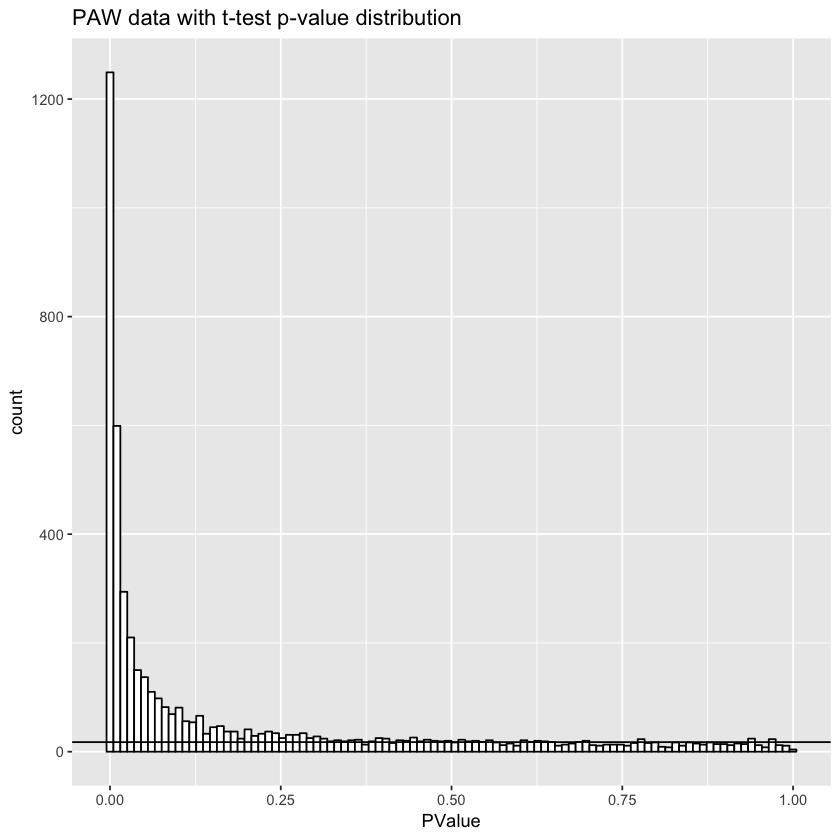

In [14]:
# copy the data
ttest_PAW <- paw_tmt_tmm

# add average ratio columns (non-logged ratios), fold-change column, and row names
ttest_PAW$ave_med <- rowMeans(paw_tmt_tmm[1:3])
ttest_PAW$ave_exo  <- rowMeans(paw_tmt_tmm[4:7])
ttest_PAW$logFC <- log2(ttest_PAW$ave_exo / ttest_PAW$ave_med)
ttest_PAW$FC <- ifelse(ttest_PAW$ave_exo > ttest_PAW$ave_med, 
                          (ttest_PAW$ave_exo / ttest_PAW$ave_med), 
                          (-1 * ttest_PAW$ave_med / ttest_PAW$ave_exo))

# apply the basic two-sample t-test (we will pool variance)
t.result <- apply(log2(paw_tmt_tmm), 1, function(x) t.test(x[1:3], x[4:7], 
                                                           var.equal = TRUE))
                  
# extract the p-value column from the t-test thingy 
ttest_PAW$PValue <- unlist(lapply(t.result, function(x) x$p.value))
                                  
# do a Benjamini-Hochberg multiple testing correction
ttest_PAW$FDR <- p.adjust(ttest_PAW$PValue, method = "BH")

# add a DE candidate status column
ttest_PAW$candidate <- cut(ttest_PAW$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))
ttest_PAW$Acc <- accession
    
# count up, down and the rest (FDR less than 0.05)
all <- dim(ttest_PAW)[1]
up <- dim(ttest_PAW[(ttest_PAW$FDR <= 0.10) & (ttest_PAW$logFC > 0.0), ])[1]
down <- dim(ttest_PAW[(ttest_PAW$FDR <= 0.10) & (ttest_PAW$logFC <= 0.0), ])[1]
print("This is like decideTest in edgeR - 10% FDR cut:")
up 
all - up - down
down
print("Candidate Counts:")
summary(ttest_PAW$candidate)
                                  
# what does the test p-value distribution look like?
pvalue_plot(ttest_PAW, "PAW data with t-test")

## Candidate numbers and p-value distribution look okay

The total up and down candidate numbers are around 1200 like we had with edgeR. The number of candidates in the different FDR classes is different. The t-test has most candidates in the medium category in contrast to edgeR where most of the candidates were in the high category. The p-value distribution is qualitatively similar. These bird's eye views all seem reasonable.

There are some options for running the t-test. We do not know much about whether the 4976 proteins have normal distributions for the 3 control samples or for the 4 exosome-dosed samples. The distribution of the 4976 (sample averaged) protein reporter ion values will have a more extreme value shape. A distribution of the log transformation of those 4976 intensities will indeed be much more Gaussian in shape. However, that is not the distribution used in the t-test. The t-test is applied to **each protein individually**. We can try the t-test on natural scale intensities and on log transformed intensities.

We have the choice of equal or unequal variance between conditions. If we assume equal variance, then we can use all 7 data points to estimate a common variance. Alternatively, we can compute the variances independently for each condition (3 and 4 data points, respectively). 

Notebooks make it easy to change these options and run all of the downstream cells to see what the effects are. I did that and tabulated candidate numbers for the table below.

|Candidate Category|Log2 Equal Var|Log2 Unequal Var|Equal Var|Unequal Var|
|------------------|--------------|----------------|---------|-----------|
|High < 0.01|727|163|705|151|
|0.05 > Med > 0.01|1282|1397|1224|1213|
|0.10 > Low > 0.05|594|769|654|922
|Non-candidate > 0.10|2373|2647|2393|2690|

The p-value distribution seems to indicate that we do have a large number of true DE candidates. That suggests that the equal variance option might be more correct for this data. Using intensities or log intensities did not make much difference. We get a handful more candidates after taking the logs, so we will use log2 intensities assuming equal variance for the rest of the notebook below.

We can look at the more detailed plots (MA plots, scatter plots, and volcano plot) to see what a deeper look into the DE candidates can tell us. We will repeat the edgeR DE plots from above for easier comparisons.

## log2FC plots

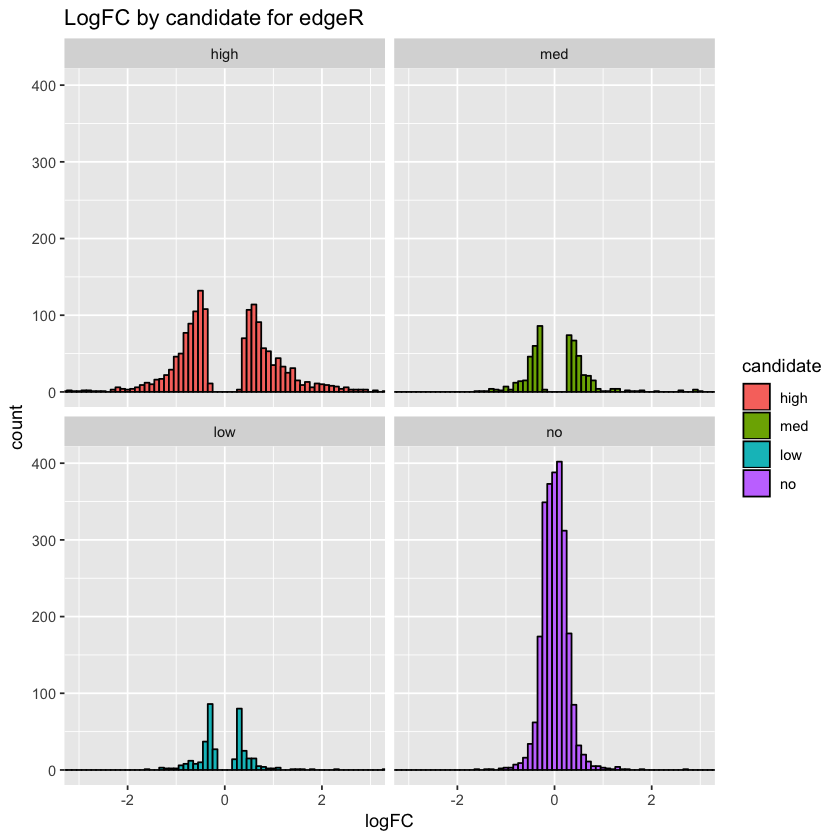

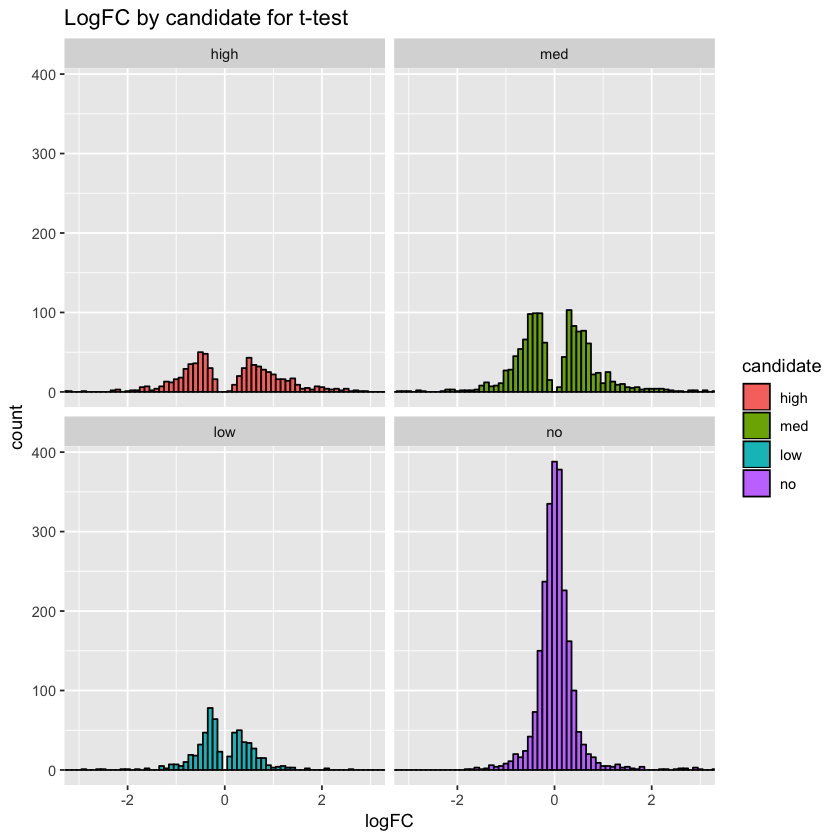

In [15]:
# can look at log2FC distributions as a check
log2FC_plots(med_exo, 3, "LogFC by candidate for edgeR")
log2FC_plots(ttest_PAW, 3, "LogFC by candidate for t-test")

### There are small fold-change proteins that are significant with the t-test

There is more of a clear progression of increasingly larger fold-change differences with low, medium, and high categories for edgeR than for the t-test. There are relatively more low and medium category proteins from the t-test.

## MA plots

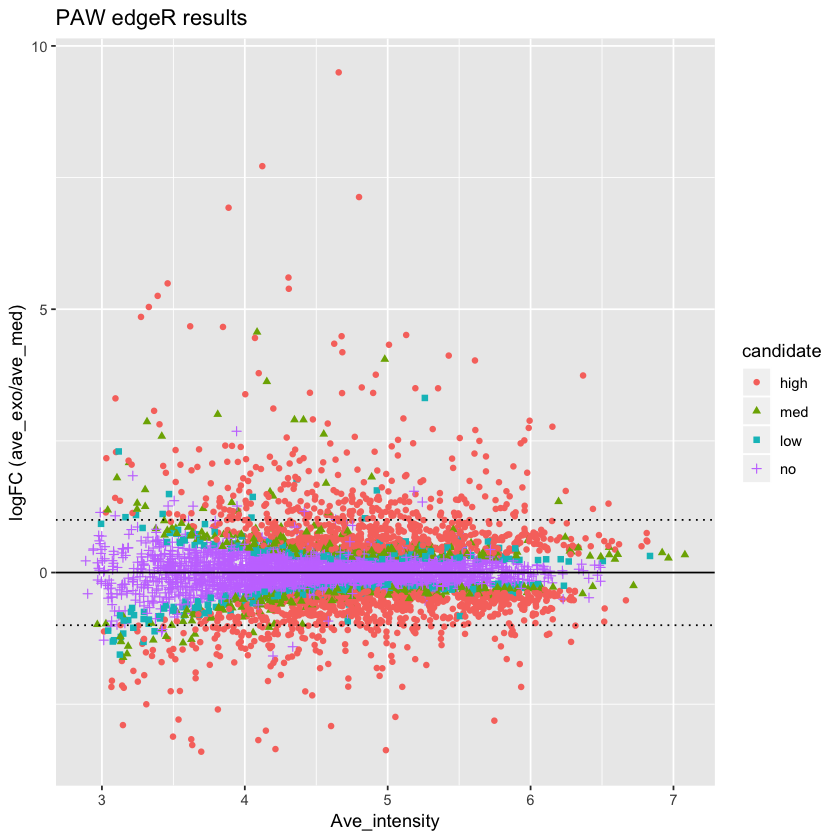

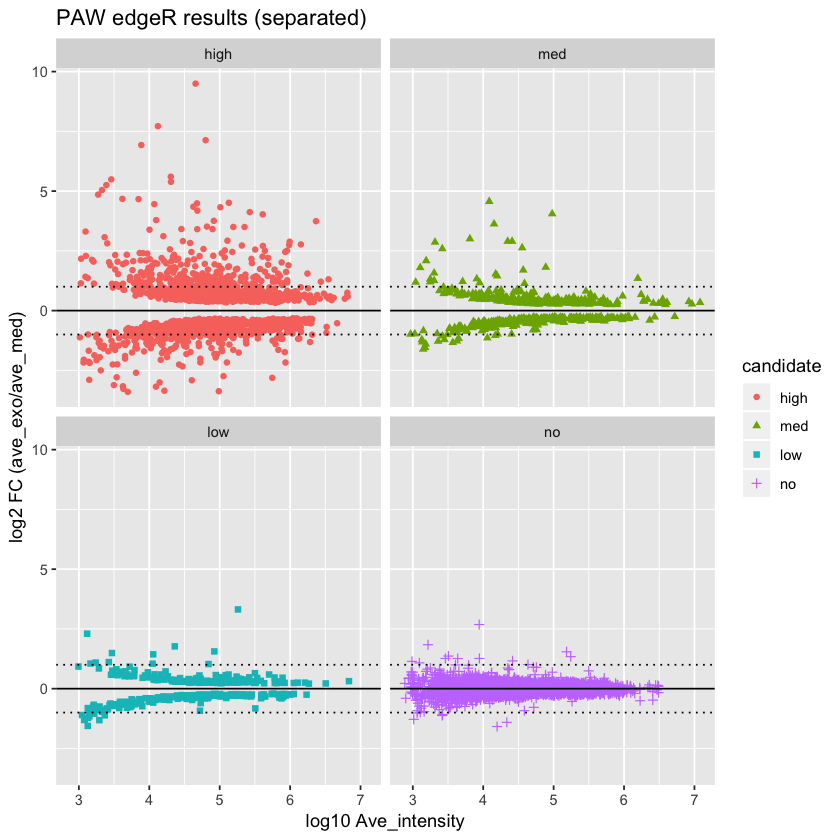

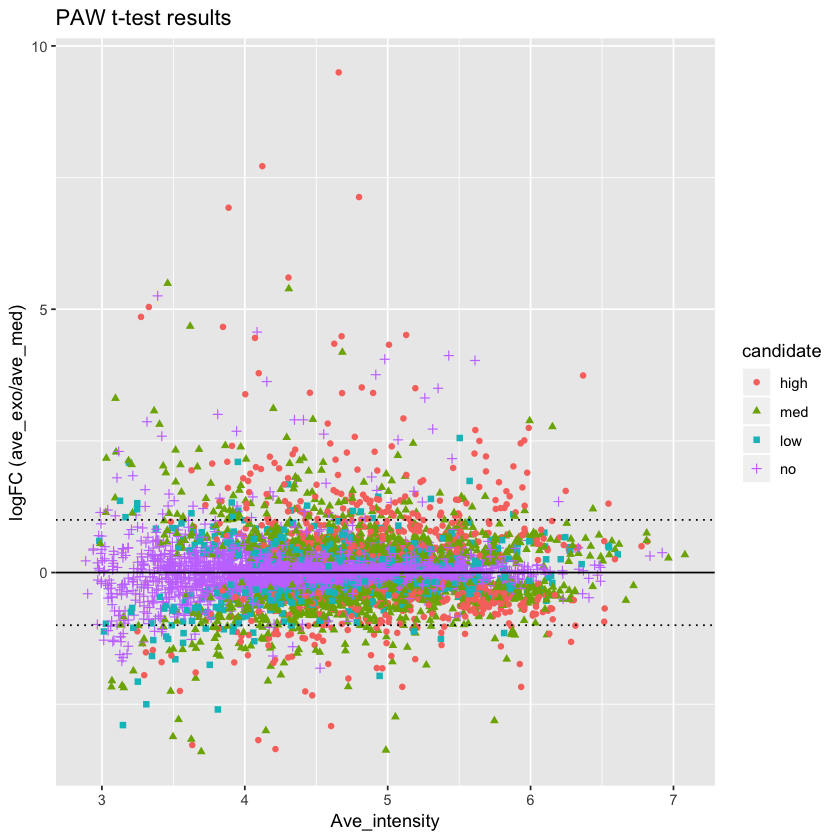

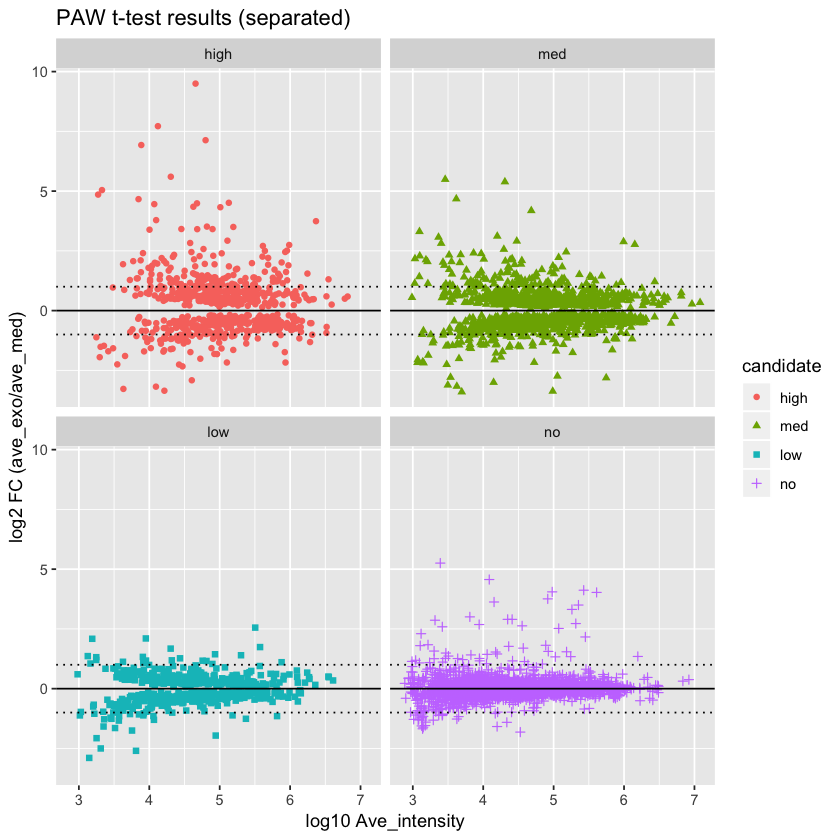

In [16]:
MA_plots(med_exo, "ave_med", "ave_exo", "PAW edgeR results")
MA_plots(ttest_PAW, "ave_med", "ave_exo", "PAW t-test results")

### There is an intensity bias to the t-test results

There are fewer "high" candidates (orange points) at both large intensities and small intensities in the t-test. This could be from higher abundance proteins having smaller mean differences due to the constrained nature of the measurements, and lower abundance proteins having higher variances. Another difference is that the "no" DE candidates in the t-test (purple points) have several points with large positive fold-changes that are not significant (high variances most likely). 

In [17]:
# the scatter plots
#scatter_plots(med_exo, "ave_med", "ave_exo", "PAW edgeR results")
#scatter_plots(ttest_PAW, "ave_med", "ave_exo", "PAW t-test results")

## Volcano plots

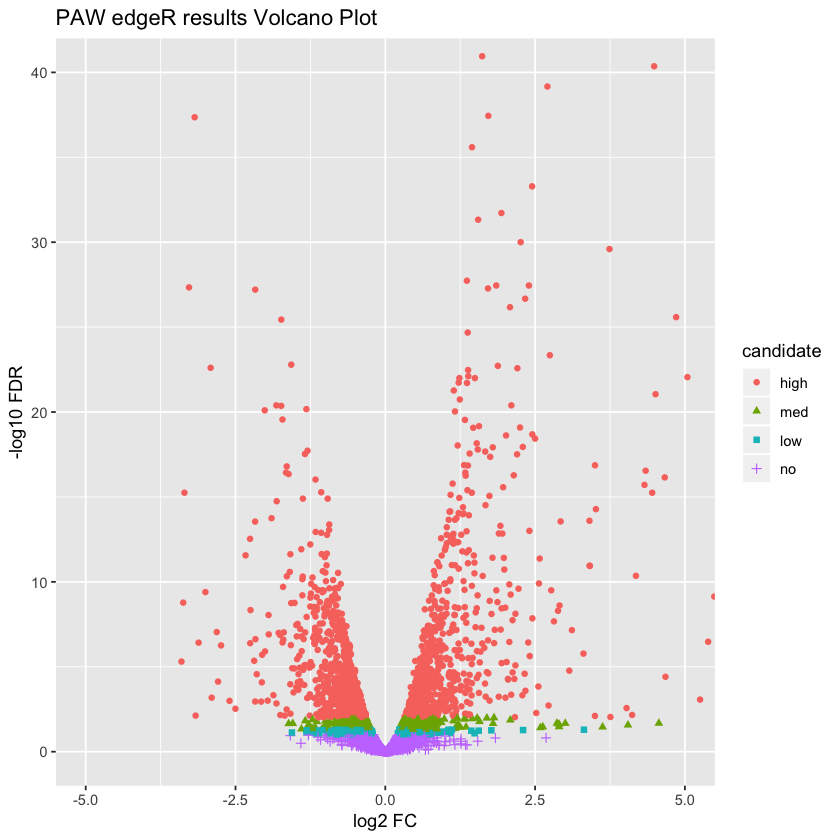

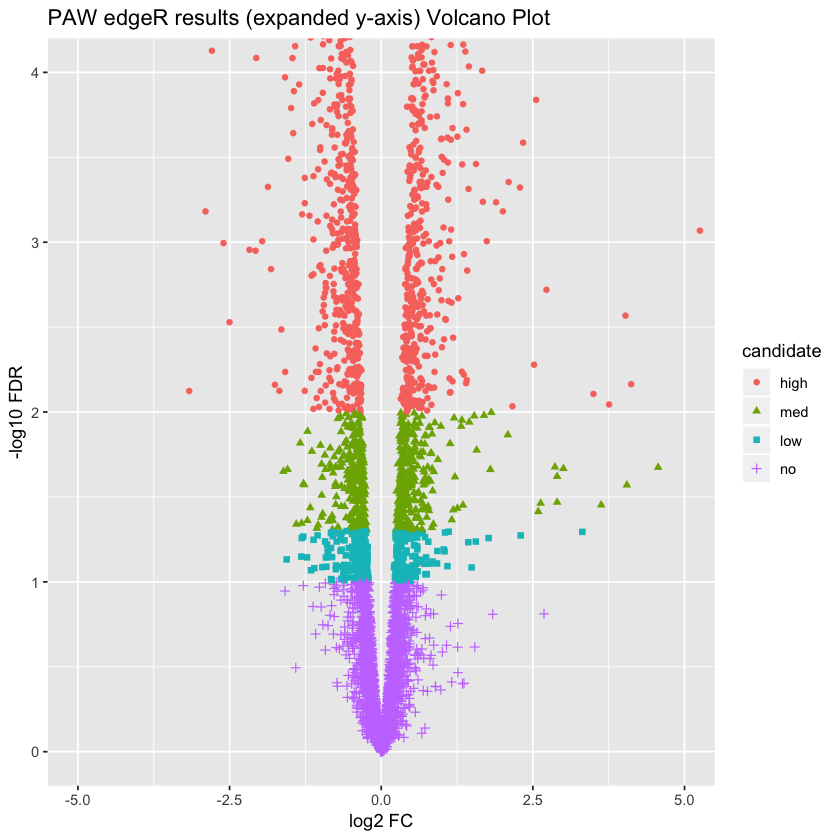

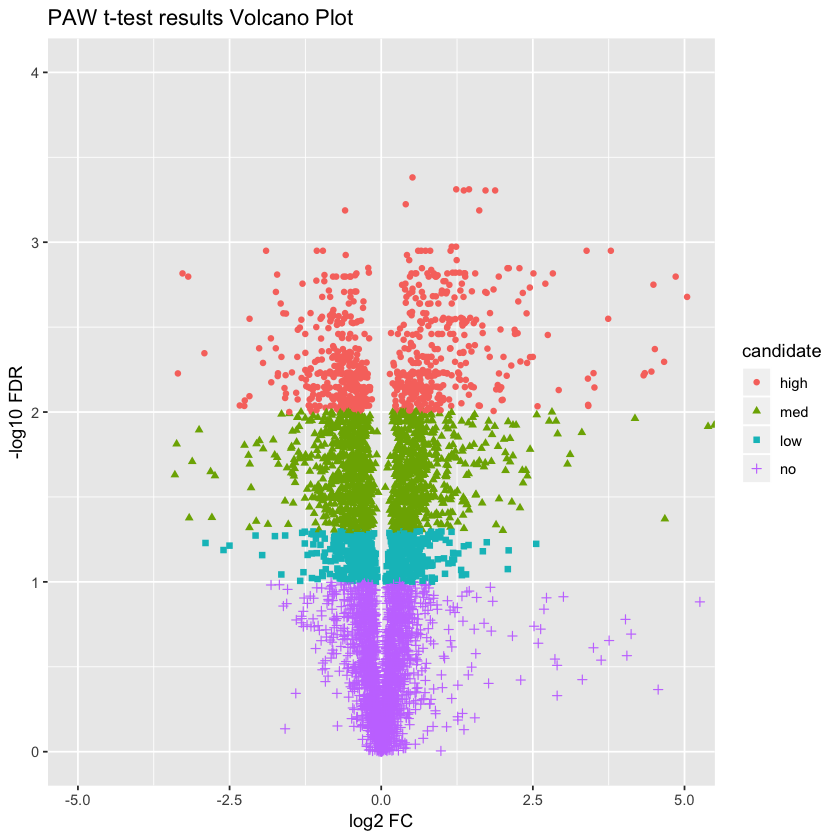

In [18]:
# compare volcano plots
volcano_plot(med_exo, "ave_med", "ave_exo", "PAW edgeR results", 40)
volcano_plot(med_exo, "ave_med", "ave_exo", "PAW edgeR results (expanded y-axis)", 4)
volcano_plot(ttest_PAW, "ave_med", "ave_exo", "PAW t-test results", 4)

### The t-test has a lot less "V" shape to its volcano plot

The range of FDR values returned by the two tests are not the same (easy to see in the volcano plots where the edgeR y-axis goes to 50 (-log10 FDR) in contrast to the t-test's maximum of 3.5). The FDR values are much more compressed in the t-test. This means that arbitrary FDR cutoffs are at different relative positions for the two sets of results. The center of the "V" is also more filled in for the t-test. 

Two tests having different ranges of p-values is why arbitrary p-value cutoffs for statistical significance can be problematic. We have overlaid the same set of cutoffs onto both sets of results. We have fewer "high" candidates in the t-test where the "medium" category is one with the most proteins. How do we decide which pattern of results seems more **correct** when we do not know the **truth**?

## What do the top 10 candidates from the t-test look like?

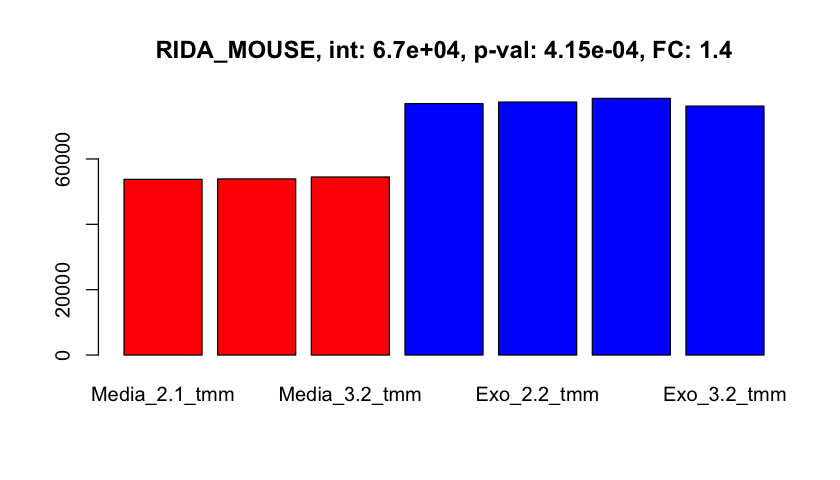

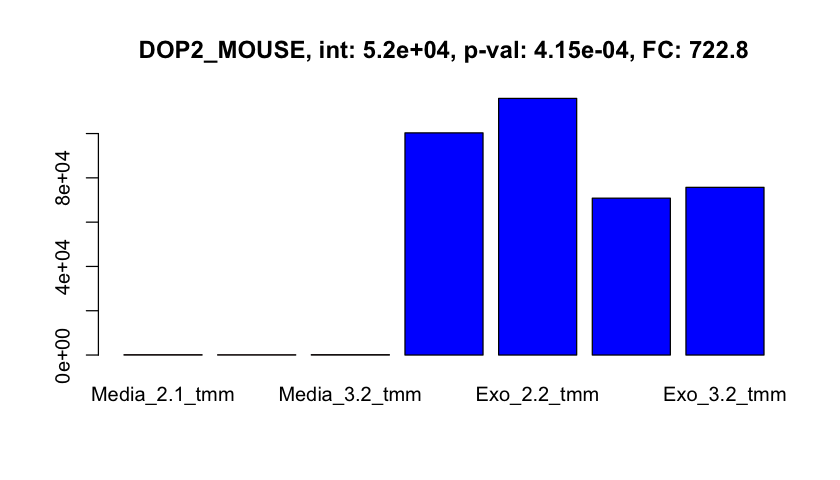

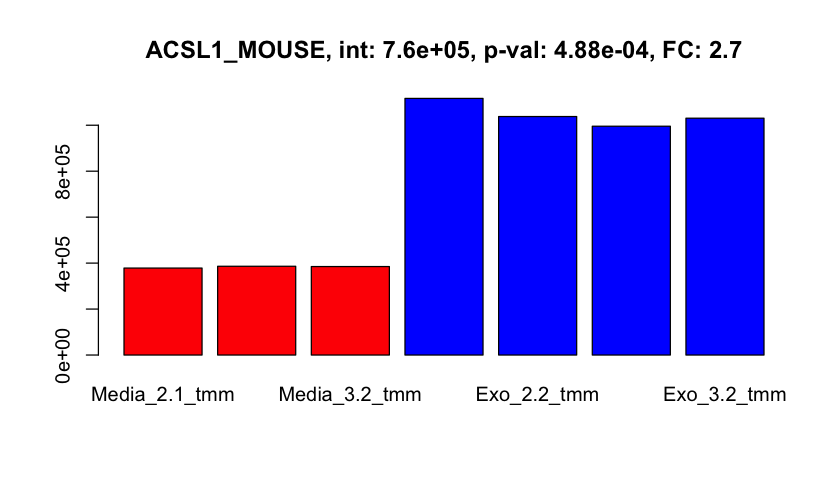

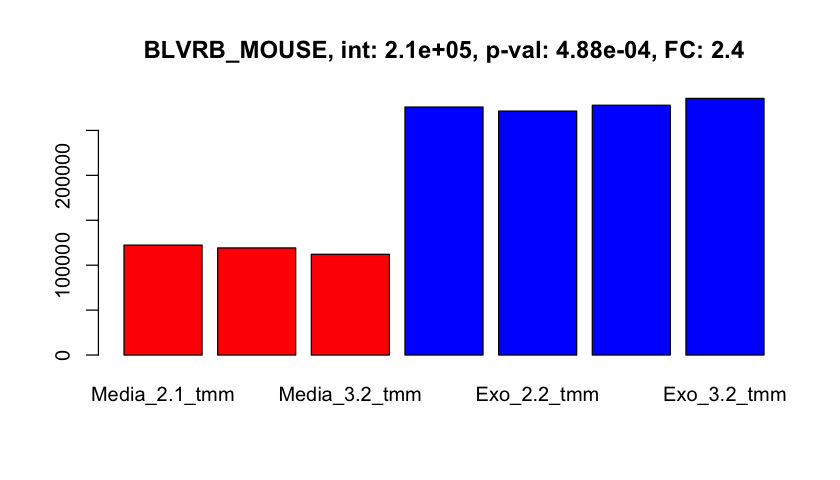

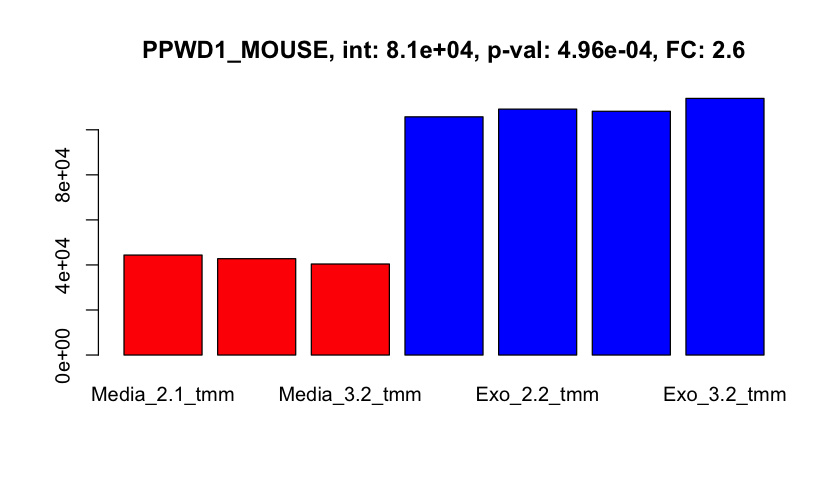

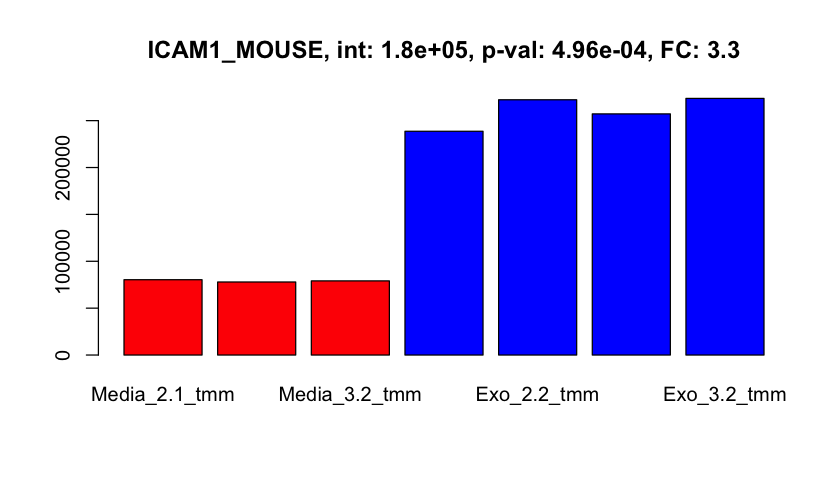

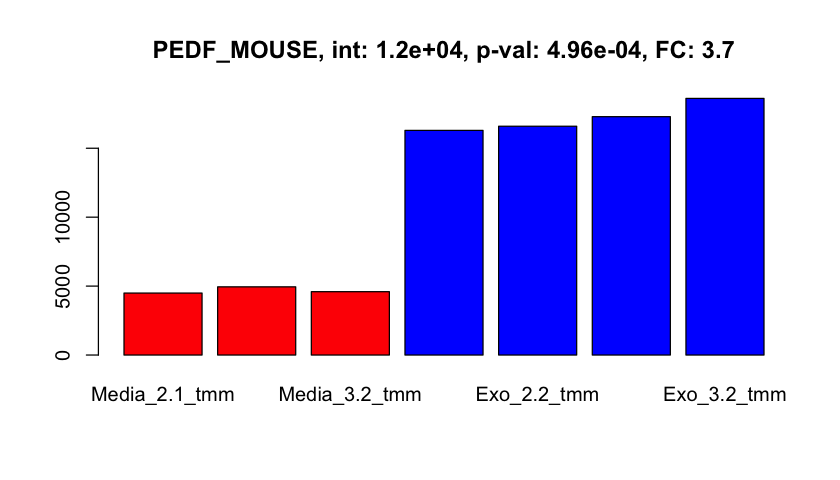

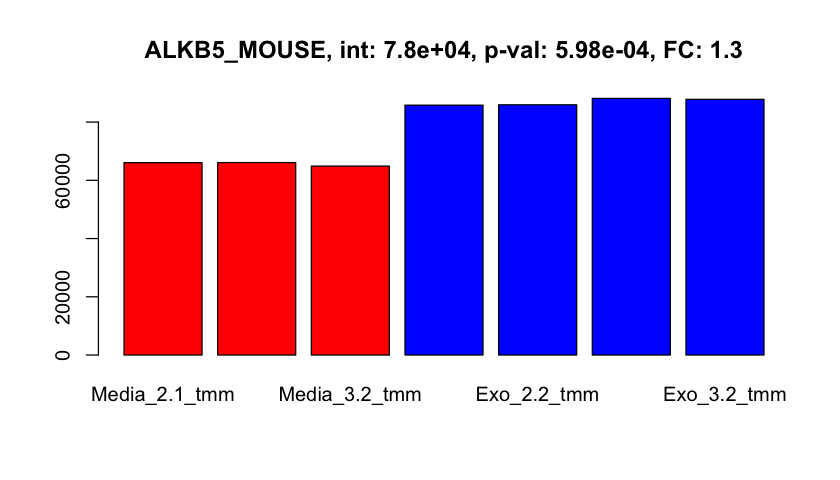

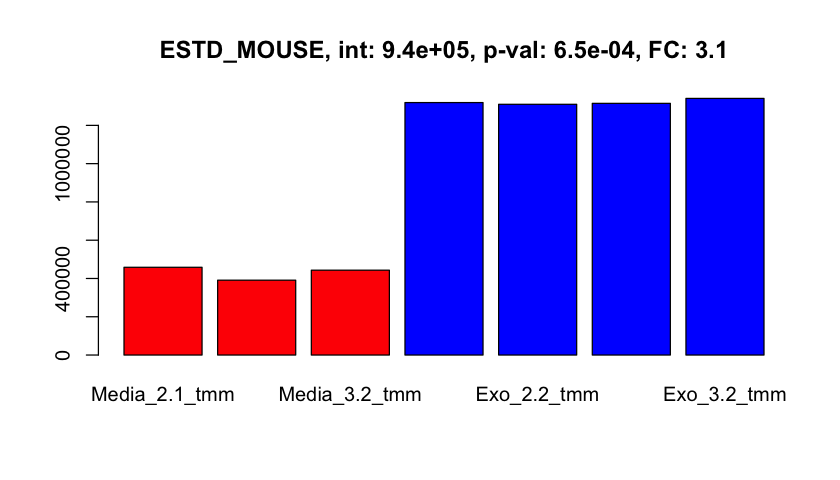

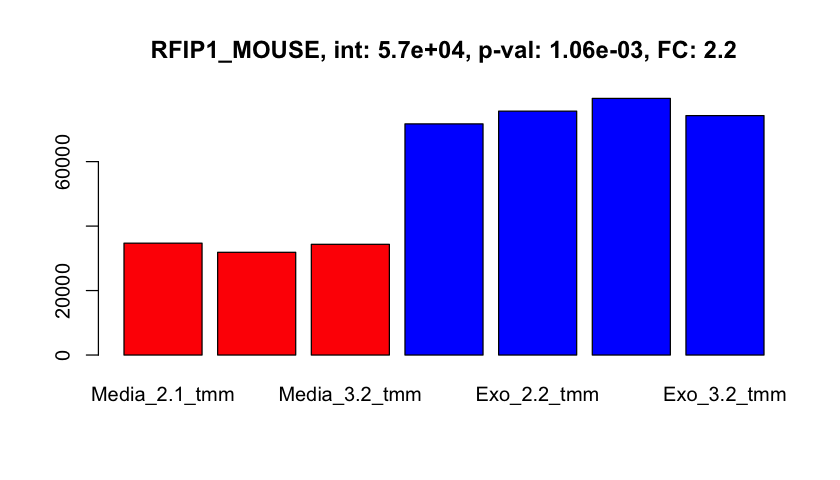

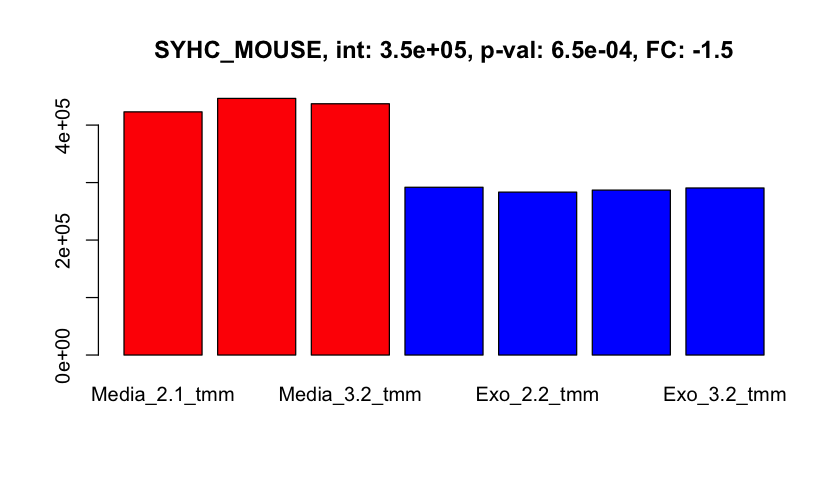

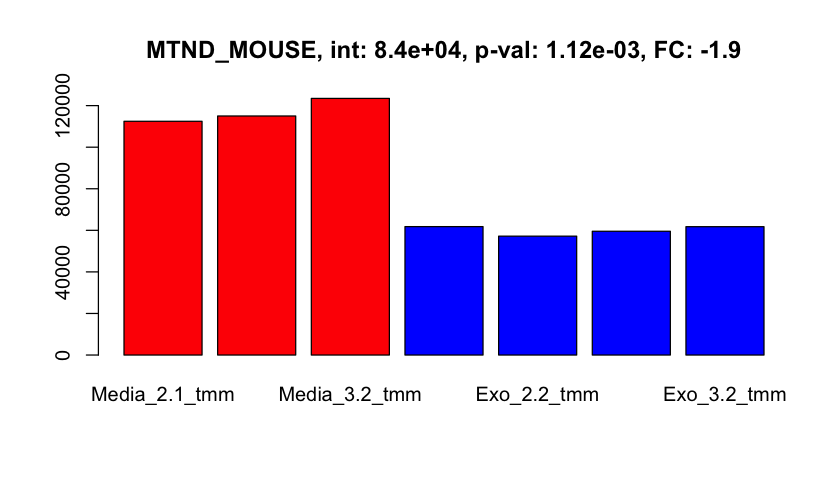

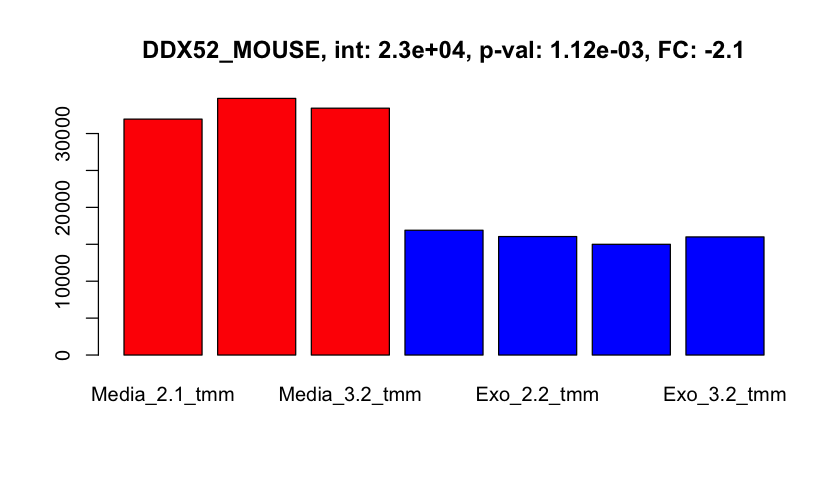

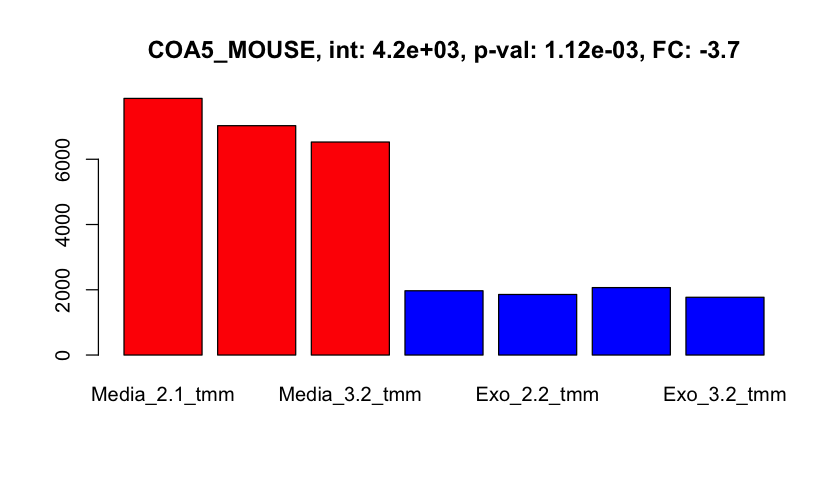

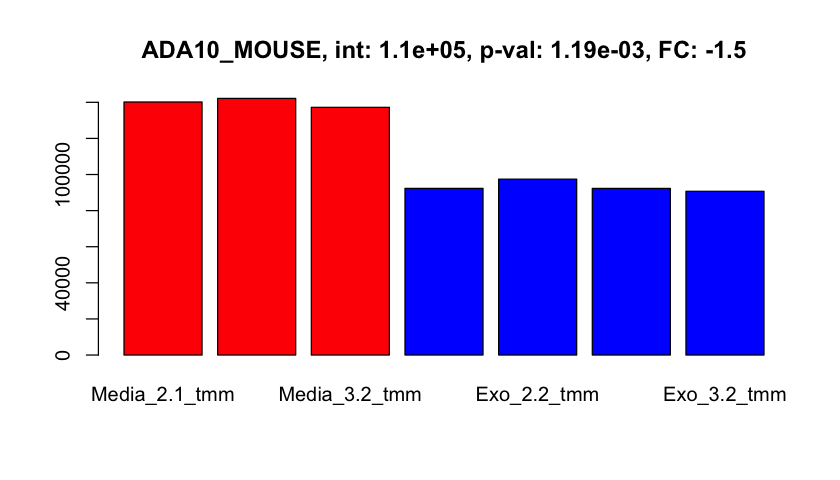

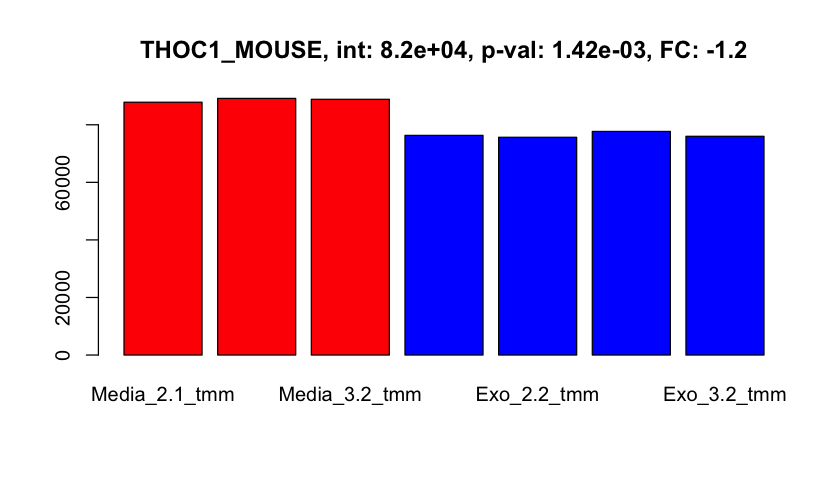

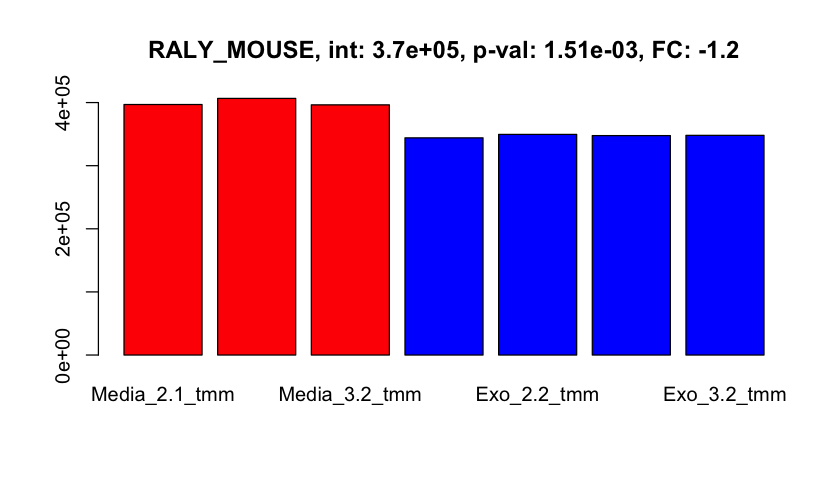

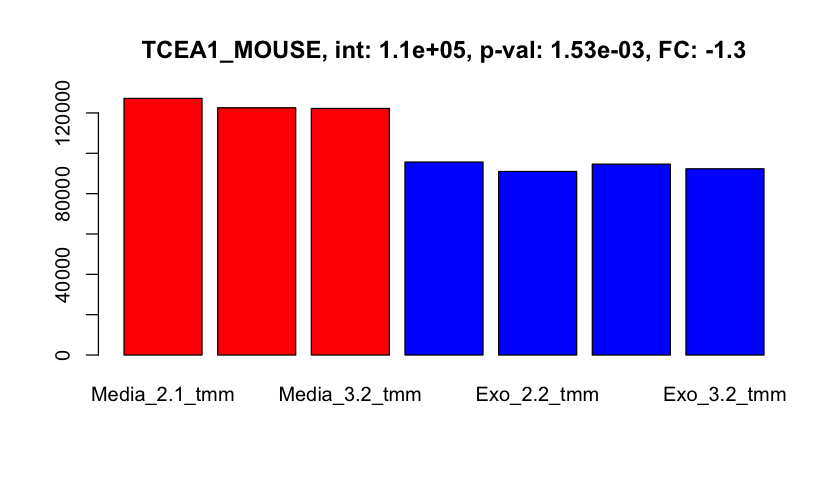

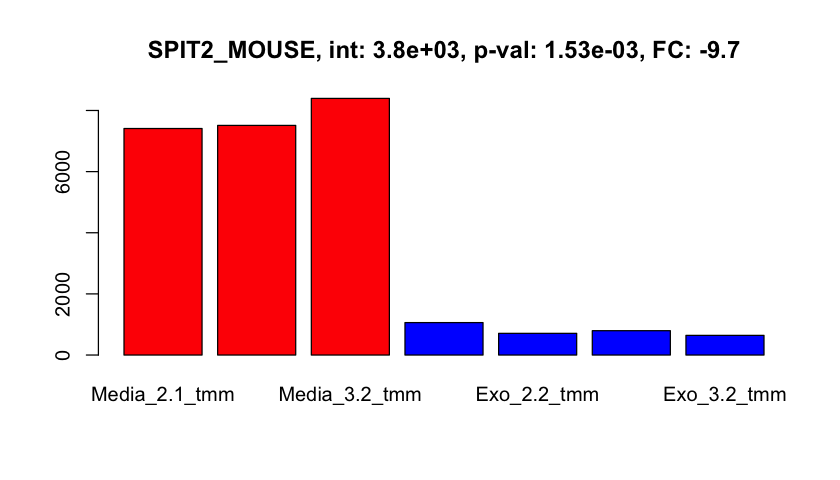

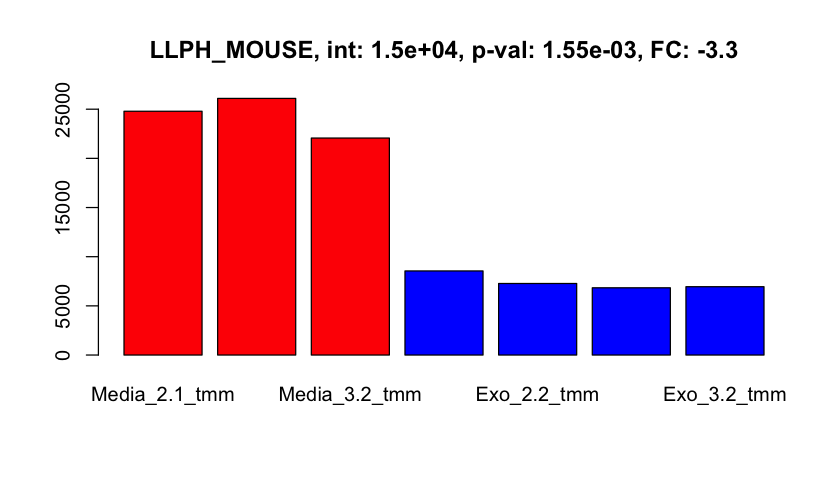

In [19]:
set_plot_dimensions(7, 4)
plot_top_tags(ttest_PAW, 3, 4, 10)
set_plot_dimensions(7, 7)

# How do the edgeR and t-test candidates compare to each other?

Comparing two sets of results in omics datasets is far more difficult than most people can imagine. It is a very **fuzzy** endeavor and most ways to compare things do not like fuzzy. We can step through the FDR thresholds and do some set comparisons (intersections, differences, etc.). 

In [20]:
for (cutoff in c(0.10, 0.05, 0.01)) {
    edgeR <- get_identifier(filter(med_exo, FDR < cutoff)$Acc)
    ttest <- get_identifier(filter(ttest_PAW, FDR < cutoff)$Acc)
    cat("cutoff:", cutoff, "\n")
    cat("number of candidates (edgeR, t-test):", length(edgeR), length(ttest), "\n")

    x_union <- union(edgeR, ttest)
    x_intersect <- intersect(edgeR, ttest)
    unique_edgeR <- setdiff(edgeR, ttest)
    unique_ttest <- setdiff(ttest, edgeR)

    cat("union and intersection:", length(x_union), length(x_intersect), "\n")
    cat("intersection out of union:", round(length(x_intersect)/length(x_union), 2), "\n")
    cat("intersection out of edgeR:", round(length(x_intersect)/length(edgeR), 2), "\n")
    cat("intersection out of t-test:", round(length(x_intersect)/length(ttest), 2), "\n")
    cat("unique to each (edgeR, ttest):", length(unique_edgeR), 
        length(unique_ttest), "\n\n")
}

edgeR_candidates <- get_identifier(filter(med_exo, FDR < 0.10)$Acc)
ttest_candidates <- get_identifier(filter(ttest_PAW, FDR < 0.10)$Acc)
unique_edgeR_candidates <- setdiff(edgeR_candidates, ttest_candidates)
unique_ttest_candidates <- setdiff(ttest_candidates, edgeR_candidates)

cat("Candidates in t-test but not candidate (<0.1) in edgeR")
interesting_ttest <- setdiff(unique_ttest_candidates, edgeR_candidates)
length(interesting_ttest)
cat("Candidates in edgeR but not candidate (<0.1) in t-test")
interesting_edgeR <- setdiff(unique_edgeR_candidates, ttest_candidates)
length(interesting_edgeR)


cat("High candidates in t-test but not candidate (<0.1) in edgeR")
interesting <- setdiff(unique_ttest, edgeR_candidates) # high t-test but not candidate in edgeR
not_interesting <- setdiff(unique_ttest, interesting) # high in t-test and also candidate in edgeR
length(interesting)

cutoff: 0.1 
number of candidates (edgeR, t-test): 2489 2603 
union and intersection: 2841 2251 
intersection out of union: 0.79 
intersection out of edgeR: 0.9 
intersection out of t-test: 0.86 
unique to each (edgeR, ttest): 238 352 

cutoff: 0.05 
number of candidates (edgeR, t-test): 2114 2009 
union and intersection: 2382 1741 
intersection out of union: 0.73 
intersection out of edgeR: 0.82 
intersection out of t-test: 0.87 
unique to each (edgeR, ttest): 373 268 

cutoff: 0.01 
number of candidates (edgeR, t-test): 1580 727 
union and intersection: 1652 655 
intersection out of union: 0.4 
intersection out of edgeR: 0.41 
intersection out of t-test: 0.9 
unique to each (edgeR, ttest): 925 72 

Candidates in t-test but not candidate (<0.1) in edgeR

[1] 352

Candidates in edgeR but not candidate (<0.1) in t-test

[1] 238

High candidates in t-test but not candidate (<0.1) in edgeR

[1] 19

### Results diverge more when the FDR cutoff is smaller

With FDR cuts of 0.10 and 0.05, the two sets of results seem somewhat similar. We have intersection numbers that are more than 70% of the union numbers. We see some bigger differences at a 0.01 cutoff. This is not really too surprising because the t-test p-values are not as small as from edgeR and they are dropping off faster. We have 72 proteins that have t-test FDRs (BH-corrected p-values) of less than 0.01 that are not also high candidates in edgeR. However, 53 of the proteins are either medium or low candidates in the edgeR testing. That leaves 19 highly significant proteins from the t-test that were not more significant than the 10% FDR in the edgeR testing. We can plot those.

### Intensities of the 19 proteins highly significant in the t-test but not significant with edgeR

In [21]:
plot_selected <- function(results, nleft, nright, selected) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # selected is list of identifiers to plot
    proteins <- results
    proteins$ident <- get_identifier(results$Acc)
    proteins <- filter(proteins, ident %in% selected)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(row$ident, ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

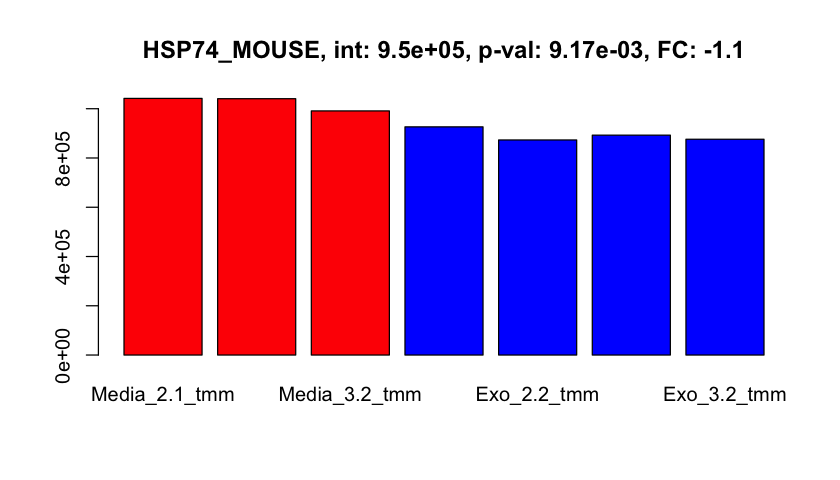

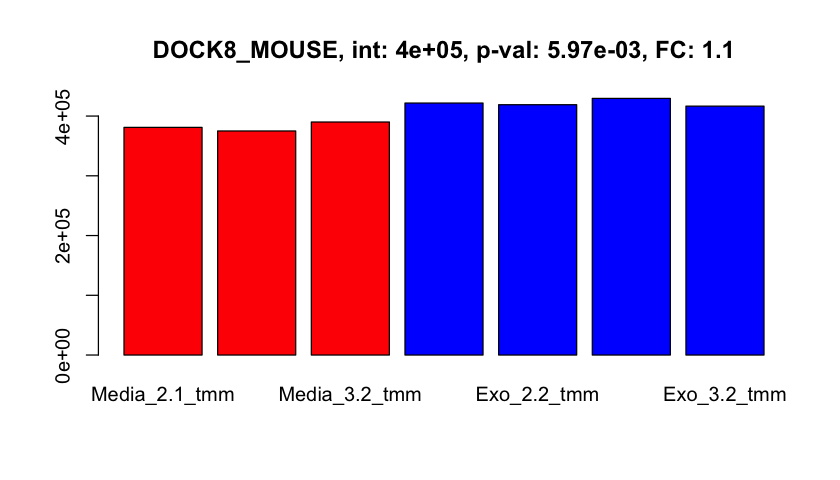

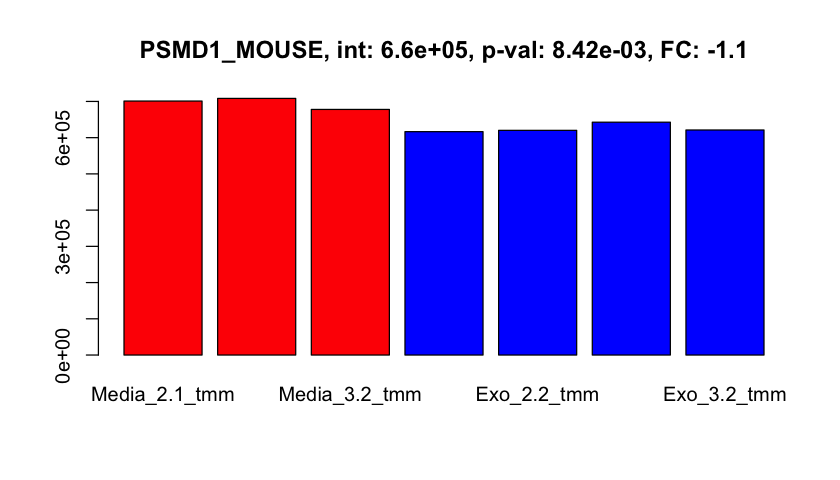

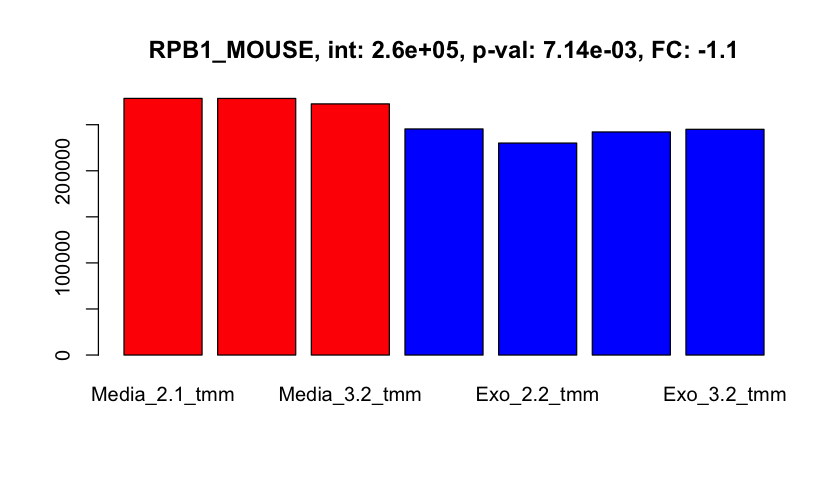

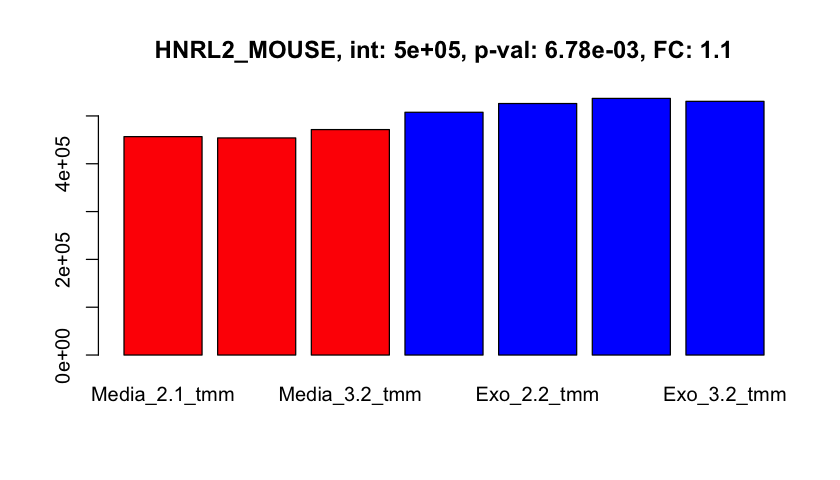

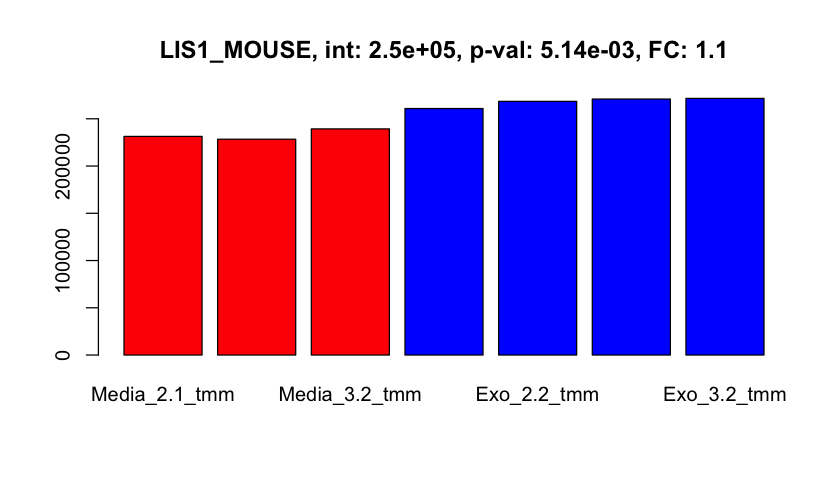

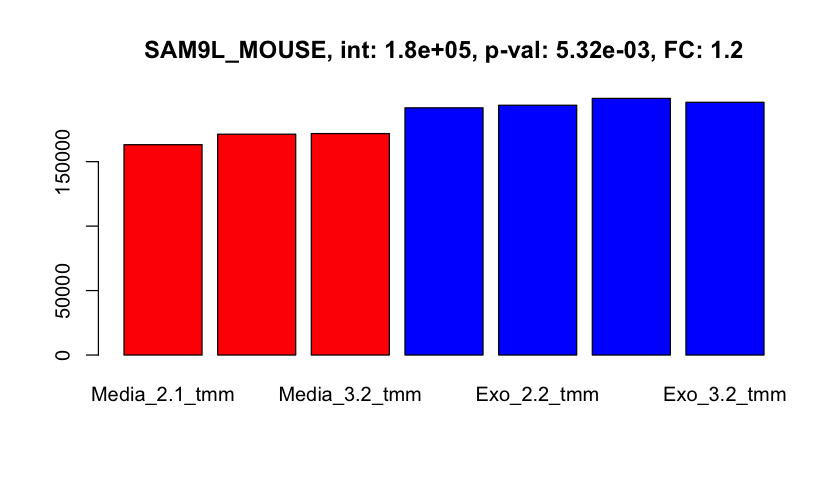

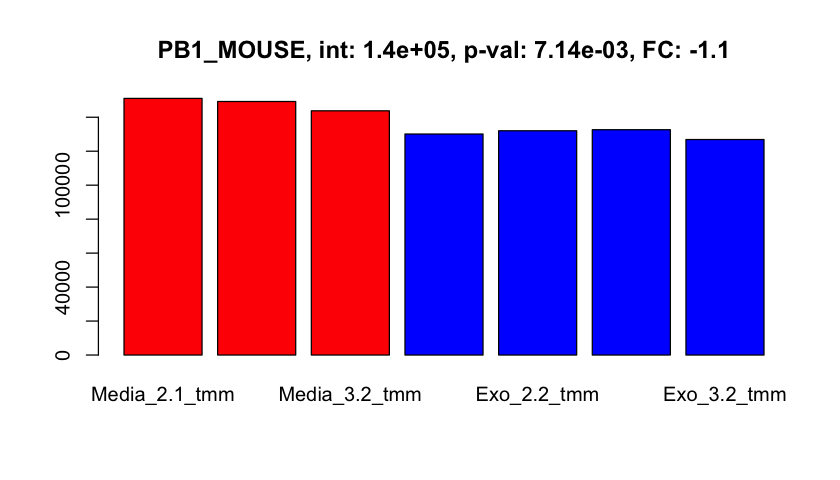

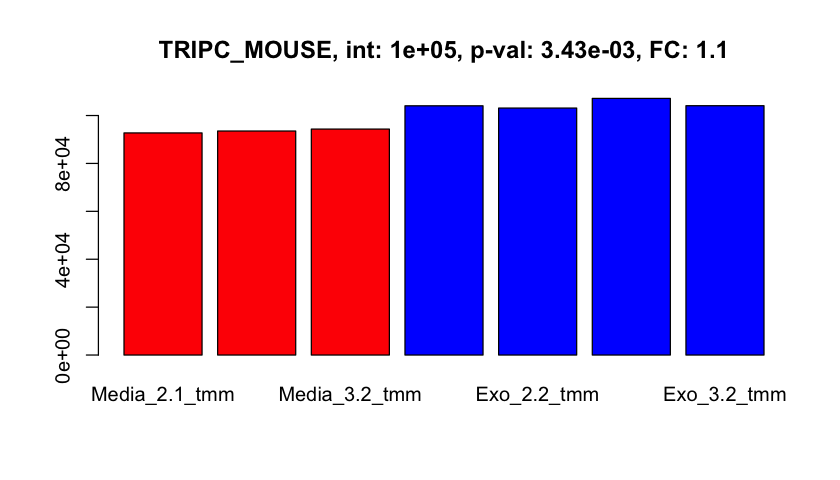

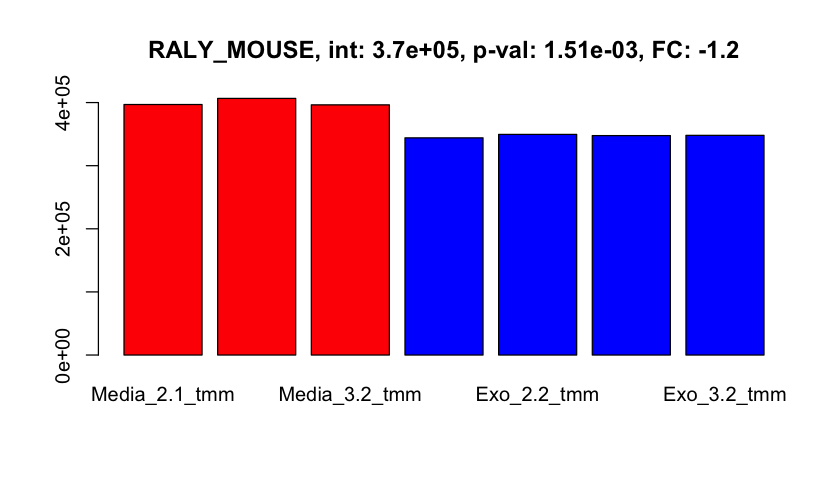

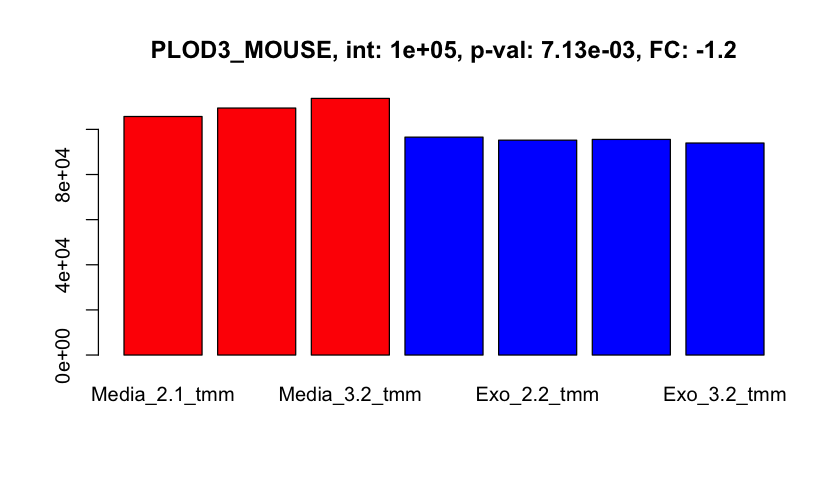

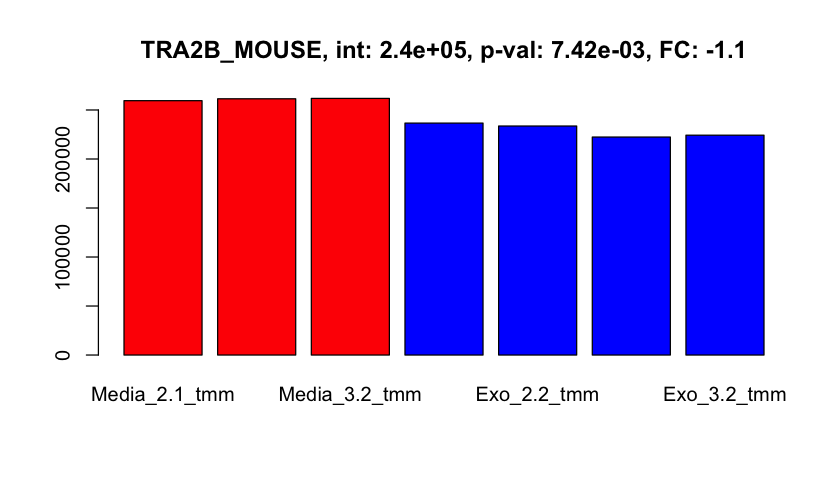

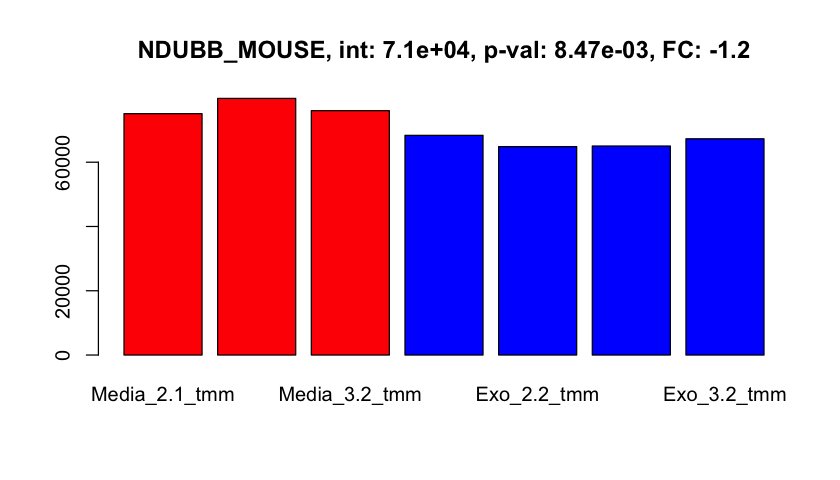

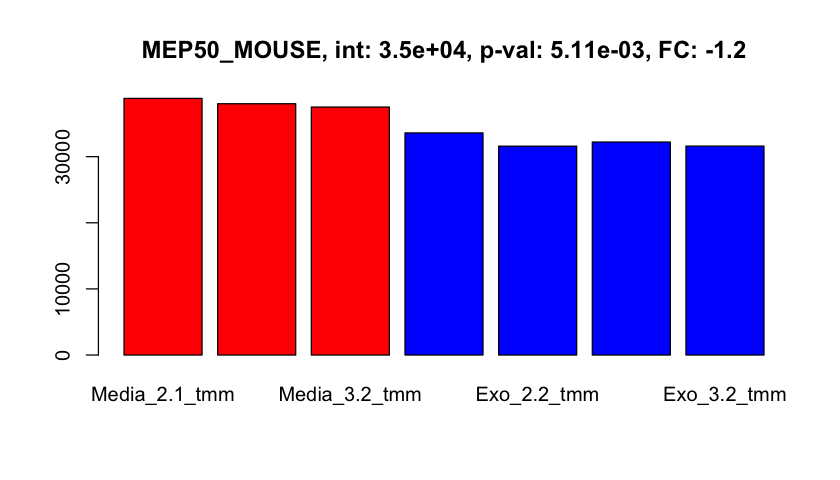

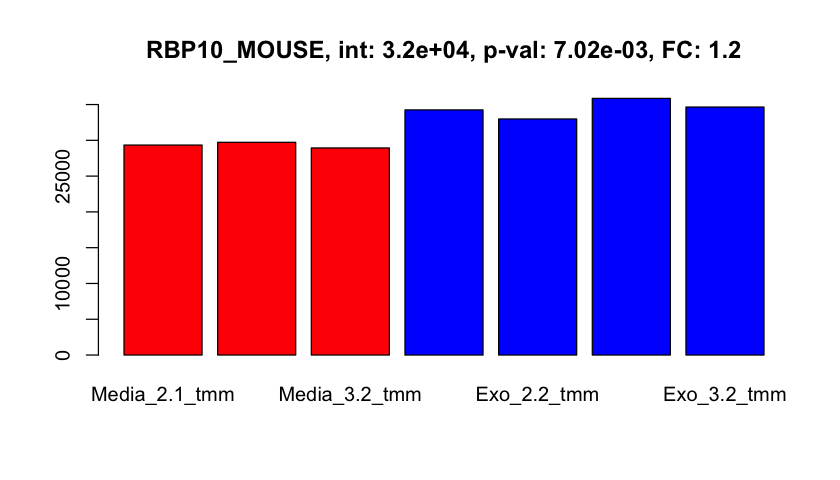

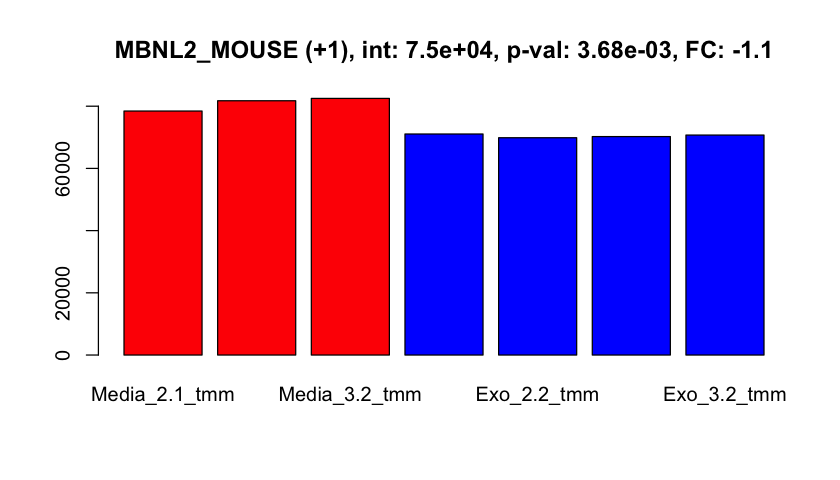

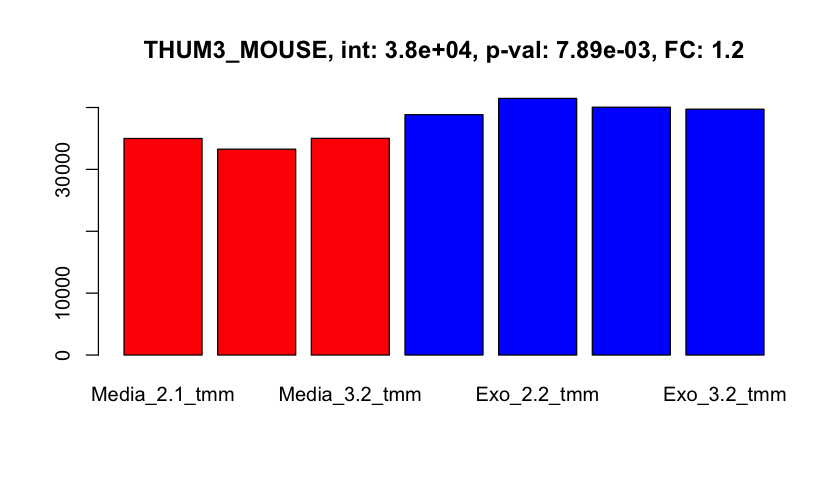

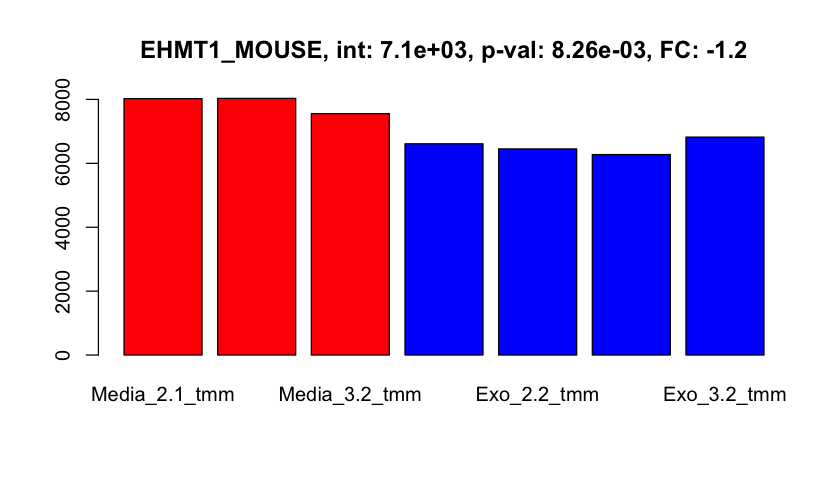

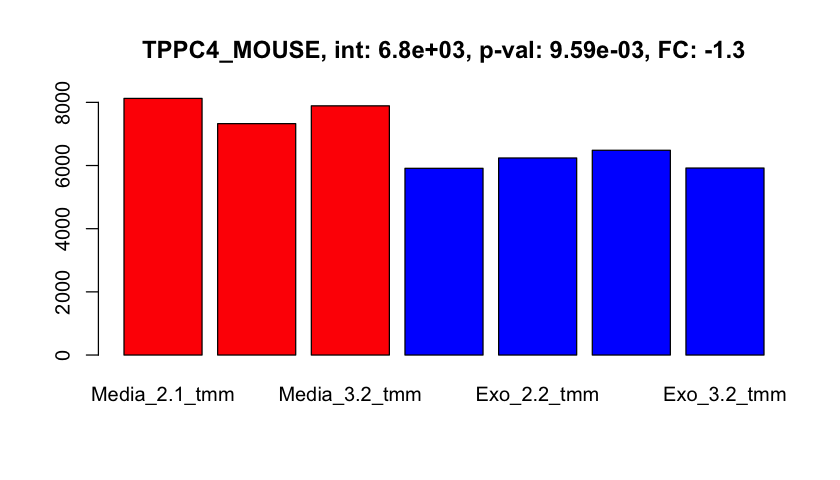

In [22]:
# plot the t-test candidates that were not significant in edgeR
set_plot_dimensions(7, 4)
plot_selected(ttest_PAW, 3, 4, interesting)
set_plot_dimensions(7, 7)

## Can we use facet plots to shed some light on the comparison?

ggplot (and visualization in general) has several ways to explore dimensionality. Different point shapes and colors can be used in the same plots. Plots can also be separated by categories and aligned to facilitate comparisons. We can do both techniques. We can color code by the candidate status in one test and facet plot by the candidate status in the other test. We might gain some useful insight or be hopelessly confused.

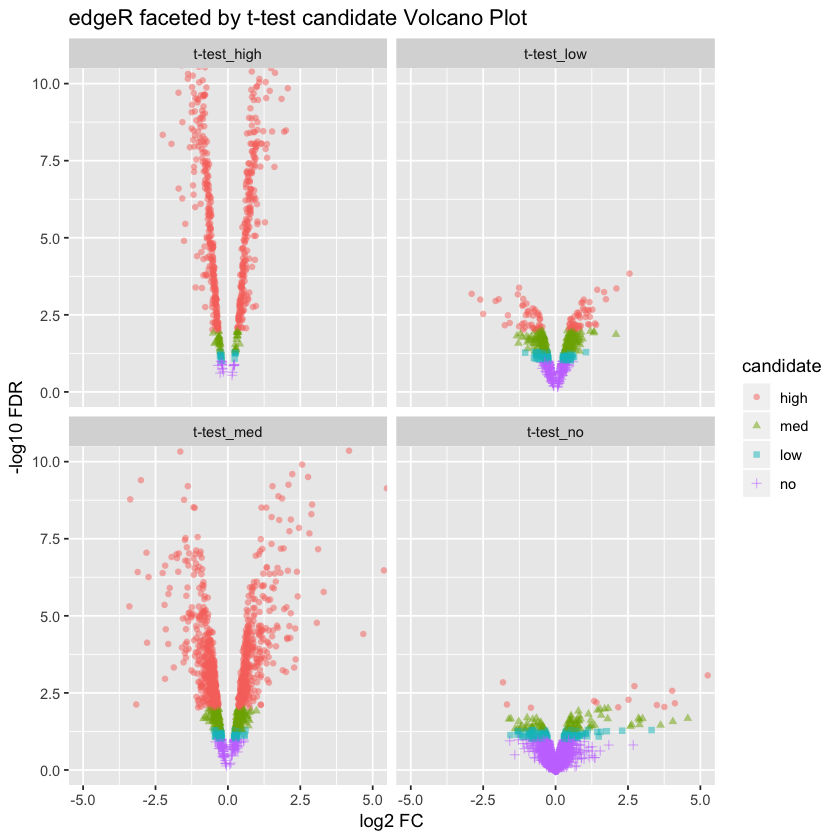

In [23]:
volcano_plot_facet <- function(results, x, y, other, title, ymax) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # ymax - upper limit for y-axis
        # title - plot title string
        # other - candidate flags from the other test
    
    # uses transformed data
    temp <- transform(results, x, y)
    temp$other <- other
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate), alpha = 0.5) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        coord_cartesian(xlim = c(-5, 5), ylim = c(0, ymax)) + 
        facet_wrap(~ other) +
        ggtitle(str_c(title, " Volcano Plot"))
}

# cross-candidate faceted volcano plots
volcano_plot_facet(med_exo, "ave_med", "ave_exo", str_c("t-test_", ttest_PAW$candidate), 
                   "edgeR faceted by t-test candidate", 10)

### Some larger fold-change proteins are significant in edgeR

Most non-candidate proteins are the same from both tests. There are a lot of purple points in the lower right panel. EdgeR has many significant candidates (in all categories) that were not candidates from the t-test; they tend to have larger fold-changes. That trend is also present in the upper right panel for the low candidates in the t-test. There were significant candidates from the t-test that were not significant in edgeR at all significance category levels in the t-test (some purple points in all 4 facets).

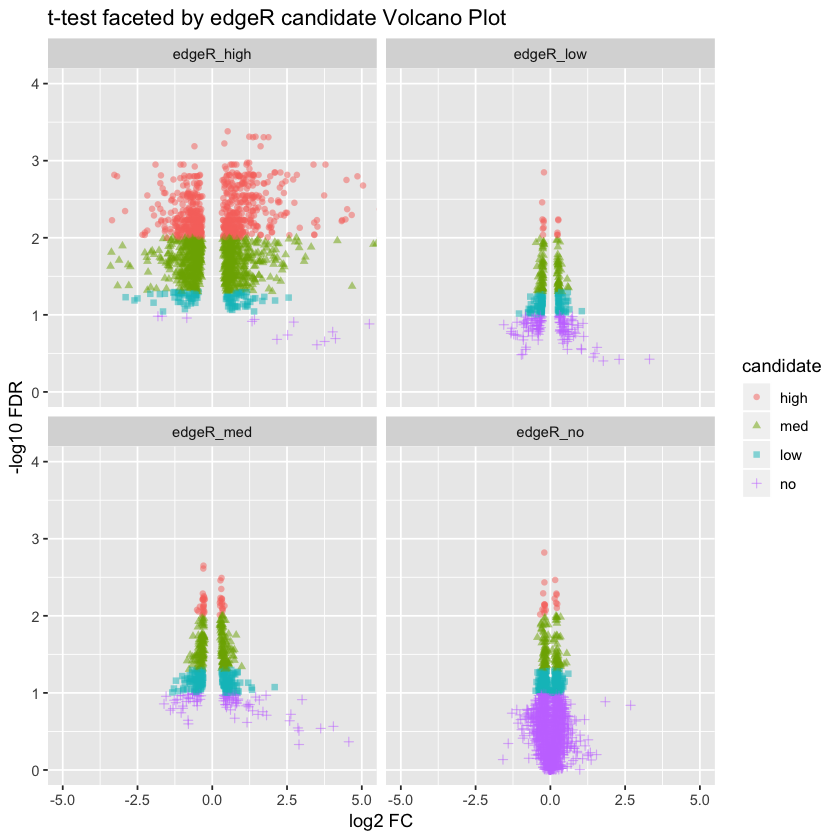

In [24]:
# with the tests switched
volcano_plot_facet(ttest_PAW, "ave_med", "ave_exo", str_c("edgeR_", med_exo$candidate), 
                   "t-test faceted by edgeR candidate", 4)

### There are many significant small fold-change proteins from the t-test

The lower right panel has many significant t-test results that were not significant in edgeR; they all have very small fold changes. From the 19 individual protein expression levels plotted a couple of cells above, these small fold-change proteins have very low variances. They may meet the mathematical criteria to be **different**, but they may not be biologically significant.

The comments about the plot of the biological coefficient of variance are reflected in these comparisons. The trended variance blue line lies above the individual protein variances in most cases. The means that there will have to be a bit more of a difference in means before edgeR will return small p-values. That effectively eliminates small fold change proteins without having to invoke an *ad hoc* cutoff. Conversely, large fold changes can overcome high variance when using moderated testing.

There are so many factors that can affect testing p-values: the data itself, normalizations and transformations, the test and test parameter choices, the underlying distribution assumption (if parametric), how trended variances are computed in moderated tests, choice of multiple testing correction method, and probably many more factors. We need better ways to explore, evaluate, and compare the choices.   

# Take home: t-test results seem worse than edgeR results

**The t-test looks less good in several ways:**

- many proteins with small fold-changes are significant
- less correlation between low p-value and large fold change
  - volcano plots are not very "V"-shaped
- less distinct candidate categorization
- statistically significant candidates have an intensity bias
- ranking top candidates looks more difficult to do

## Log the session information
One step towards more meaningful results summaries are getting the main proteomics results and the statistical results combined into a single table. If we are careful with how we bring the data into R and how we take it back out, we can keep tables in order so merging results are easier. We kept the accessions column as we worked with the data. We can be really robust and use merge functions to weave together starting tables with final results tables using the accessions as keys. 

We should always end notebooks with information about what packages and versions were used in the analysis.

In [25]:
# save the testing results
#write.table(med_exo, file = "KUR1502_results.txt", sep = "\t",
#            row.names = FALSE, na = " ")

# log the session
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] edgeR_3.24.3    limma_3.38.3    scales_1.0.0    gridExtra_2.3  
 [5] psych_1.8.12    forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1  
 [9] purrr_0.3.2     readr_1.3.1     tidyr_0.8.3     tibble_2.1.1   
[13] ggplot2_3.1.1   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     locfit_1.5-9.1   tidyselect_0.2.5 repr_0.19.2     
 [5] splines_3.5.3    haven_2.1.0      lattice_0.20-38  colorspace_1.4-1
 [9] generics_0.0.2   htmltools_0.3.6  base64enc_0.1-3  rlang_0.